# References

This notebook contains analysis of certificate references in Common Criteria certificates.

In [1]:
import itertools
import json
import warnings
from collections.abc import Iterable
from datetime import datetime
from pathlib import Path
from typing import Literal

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from notebooks.fixed_sankey_plot import sankey
from scipy import stats
from tqdm import tqdm

from sec_certs.dataset.cc import CCDataset
from sec_certs.utils.parallel_processing import process_parallel

# Surpress user warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

# LaTeX plotting
# matplotlib.use("pgf")
# plt.rcParams["pgf.texsystem"] = "pdflatex"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["text.usetex"] = True
# plt.rcParams["pgf.rcfonts"] = False


sns.set_theme(style="white")
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 6.5
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.major.pad"] = 0

plt.rcParams["axes.titlesize"] = 8
plt.rcParams["legend.handletextpad"] = 0.3
plt.rcParams["lines.markersize"] = 0.5
plt.rcParams["savefig.pad_inches"] = 0.01
sns.set_palette("deep")

plt.style.use("default")
sns.set_palette("deep")
sns.set_context("paper")  # Set to "paper" for use in paper :)

# plt.rcParams['figure.figsize'] = (10, 6)

REPO_ROOT = Path().resolve()
RESULTS_DIR = Path("./results/references")
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

DATASET_PATH = REPO_ROOT / "dataset/cc_november_23/dataset.json"
PREDICTIONS_PATH = REPO_ROOT / "dataset/reference_prediction/predictions.csv"

SMARTCARD_CATEGORY = "ICs, Smart Cards and Smart Card-Related Devices and Systems"
CARD_RELATED_CAT = {"Other Devices and Systems", "Products for Digital Signatures", "Trusted Computing"}
OTHERS_CAT = {
    "Access Control Devices and Systems",
    "Biometric Systems and Devices",
    "Boundary Protection Devices and Systems",
    "Data Protection",
    "Databases",
    "Detection Devices and Systems",
    "Key Management Systems",
    "Mobility",
    "Multi-Function Devices",
    "Network and Network-Related Devices and Systems",
    "Operating Systems",
}

## Common processing functions

In [2]:
def len_if_exists(x) -> int:
    return len(x) if pd.notnull(x) else 0


def get_label_subgraph(graph: nx.DiGraph, label: str | Iterable[str]) -> nx.DiGraph:
    label = label if isinstance(label, Iterable) else [label]
    sub_edges = [(u, v) for u, v, d in graph.edges(data=True) if d.get("reference_label") in label]
    return graph.edge_subgraph(sub_edges)


def compute_reference_numbers(df__: pd.DataFrame) -> pd.DataFrame:
    """
    Creates new columns with number of references for each certificate.
    """
    return df__.copy().assign(
        n_refs=lambda df_: df_.refs.map(len_if_exists),
        n_trans_refs=lambda df_: df_.trans_refs.map(len_if_exists),
        n_in_refs=lambda df_: df_.in_refs.map(len_if_exists),
        n_in_trans_refs=lambda df_: df_.in_trans_refs.map(len_if_exists),
    )


def preprocess_cc_df(cc_df: pd.DataFrame) -> pd.DataFrame:
    """
    Pre-processing run on the CC dataset for the sake of this notebook.
    """

    def choose_archival_date(not_valid_before):
        return max(datetime(2019, 6, 1), not_valid_before + pd.Timedelta(days=(5 * 365) + 2))

    return (
        cc_df.loc[cc_df.cert_id.notnull()]
        .copy()
        .rename(
            columns={
                "directly_referencing": "refs",
                "indirectly_referencing": "trans_refs",
                "directly_referenced_by": "in_refs",
                "indirectly_referenced_by": "in_trans_refs",
            }
        )
        # Old date computation
        # .assign(
        #     longer_than_5_years=lambda df_: df_.not_valid_after - df_.not_valid_before
        #     > pd.Timedelta(days=(5 * 365) + 2),
        #     not_valid_after=lambda df_: df_.not_valid_after.where(
        #         ~df_.longer_than_5_years, df_.not_valid_before + pd.Timedelta(days=(5 * 365) + 2)
        #     ),
        # )
        .assign(
            longer_than_5_years=lambda df_: df_.not_valid_after - df_.not_valid_before
            > pd.Timedelta(days=(5 * 365) + 2),
            not_valid_after=lambda df_: df_.not_valid_after.where(
                ~df_.longer_than_5_years, df_.not_valid_before.apply(choose_archival_date)
            ),
        )
        .drop_duplicates(subset=["cert_id"], keep="first")  # TODO: Investigate high number of duplicates and resolve
    )


def compute_references(cc_df: pd.DataFrame, graph: nx.DiGraph, label: str | Iterable[str]) -> pd.DataFrame:
    """
    Limits the columns with references to a given label.
    """
    subgraph = get_label_subgraph(graph, label)

    return cc_df.assign(
        refs=lambda df_: df_.apply(
            lambda row: set(subgraph.successors(row.cert_id)) if row.cert_id in subgraph else np.nan,
            axis=1,
        ),
        trans_refs=lambda df_: df_.apply(
            lambda row: set(nx.descendants(subgraph, row.cert_id)) if row.cert_id in subgraph else np.nan, axis=1
        ),
        in_refs=lambda df_: df_.apply(
            lambda row: set(subgraph.predecessors(row.cert_id)) if row.cert_id in subgraph else np.nan,
            axis=1,
        ),
        in_trans_refs=lambda df_: df_.apply(
            lambda row: set(nx.ancestors(subgraph, row.cert_id)) if row.cert_id in subgraph else np.nan, axis=1
        ),
    )


def preprocess_refs_df(csv_path: str | Path, cc_df: pd.DataFrame) -> pd.DataFrame:
    return (
        pd.read_csv(csv_path)
        .pipe(lambda df_: df_.loc[df_.dgst.isin(cc_df.index)])
        .assign(cert_id=lambda df_: df_.dgst.map(cc_df.cert_id.to_dict()))
    )


def get_reference_graph_from_refs_df(refs_df: pd.DataFrame) -> nx.DiGraph:
    return nx.from_pandas_edgelist(
        refs_df,
        source="cert_id",
        target="reference",
        create_using=nx.DiGraph,
        edge_attr=["reference_label"],
    )


def get_plotly_node_edge_traces(G: nx.DiGraph, cc_dset: CCDataset) -> tuple[go.Scatter, go.Scatter]:
    pos = nx.spring_layout(G)

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(x=edge_x, y=edge_y, line={"width": 0.5, "color": "#888"}, hoverinfo="none", mode="lines")

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        hoverinfo="text",
        marker={
            "showscale": True,
            "colorscale": "Viridis",
            "reversescale": True,
            "color": [],
            "size": 10,
            "colorbar": {"thickness": 15, "title": "Node Connections", "xanchor": "left", "titleside": "right"},
            "line_width": 2,
        },
    )

    node_adjacencies = []
    node_text = []
    node_name_mapping = dict(enumerate(G.nodes()))
    cert_id_to_dgst = {x.heuristics.cert_id: x.dgst for x in cc_dset}
    for node, adjacencies in enumerate(nx.reverse_view(G).adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(
            f"{node_name_mapping[node]} ({cert_id_to_dgst[node_name_mapping[node]]}) (# conns: {len(adjacencies[1])})"
        )

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    return node_trace, edge_trace


def plotly_draw(graph: nx.DiGraph, cc_dset: CCDataset):
    plt.figure(figsize=(7, 7))
    node_trace, edge_trace = get_plotly_node_edge_traces(graph, cc_dset)
    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            title="<br>Network graph made with Python",
            titlefont_size=16,
            showlegend=False,
            hovermode="closest",
            margin={"b": 20, "l": 5, "r": 5, "t": 40},
            annotations=[
                {
                    "text": "Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    "showarrow": False,
                    "xref": "paper",
                    "yref": "paper",
                    "x": 0.005,
                    "y": -0.002,
                }
            ],
            xaxis={"showgrid": False, "zeroline": False, "showticklabels": False},
            yaxis={"showgrid": False, "zeroline": False, "showticklabels": False},
        ),
    )
    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
    )
    fig.show()


def find_reach_over_time(df_: pd.DataFrame, cert_id: str, date_range: pd.DatetimeIndex) -> pd.Series:
    df = df_.copy().loc[lambda df_: df_.trans_refs.apply(lambda x: pd.notnull(x) and cert_id in x)]
    dct = {date: df.loc[(date >= df.not_valid_before) & (date <= df.not_valid_after)].shape[0] for date in date_range}
    return pd.Series(dct, name=cert_id)

## Load data and compute reference graph

In [3]:
dset = CCDataset.from_json(DATASET_PATH)
cc_df = preprocess_cc_df(dset.to_pandas())
refs_df = preprocess_refs_df(PREDICTIONS_PATH, cc_df)
unique_labels = refs_df.reference_label.unique().tolist()

# Load labeled reference graph as networkx directed graph
graph = nx.from_pandas_edgelist(
    refs_df,
    source="cert_id",
    target="canonical_reference_keyword",
    edge_attr="reference_label",
    create_using=nx.DiGraph,
)
comp_subgraph = get_label_subgraph(graph, "COMPONENT_USED")
prev_subgraph = get_label_subgraph(graph, "PREVIOUS_VERSION")

cc_df = compute_reference_numbers(compute_references(cc_df, graph, unique_labels))
cc_df_comp = compute_reference_numbers(compute_references(cc_df, graph, "COMPONENT_USED"))
cc_df_prev = compute_reference_numbers(compute_references(cc_df, graph, "PREVIOUS_VERSION"))
assert cc_df.n_refs.sum() == cc_df_comp.n_refs.sum() + cc_df_prev.n_refs.sum()

In [21]:
cc_df.loc[(cc_df.status == "active") & (cc_df.category == SMARTCARD_CATEGORY)].shape

(606, 31)

In [13]:
cc_df.eal.value_counts()

eal
EAL4+    1308
EAL5+     805
EAL2+     697
EAL3+     401
EAL2      400
EAL1      323
EAL3      305
EAL6+     207
EAL4      154
EAL1+      53
EAL5       29
EAL7        9
EAL7+       4
EAL6        2
Name: count, dtype: int64

In [10]:
cc_df.status.value_counts()

status
archived    3771
active      1623
Name: count, dtype: int64

/tmp/ipykernel_2939850/3289815995.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sec_levels = cc_df.loc[cc_df.year_from < 2023].groupby(["year_from", "eal"], as_index=False).size()


<Figure size 640x480 with 0 Axes>

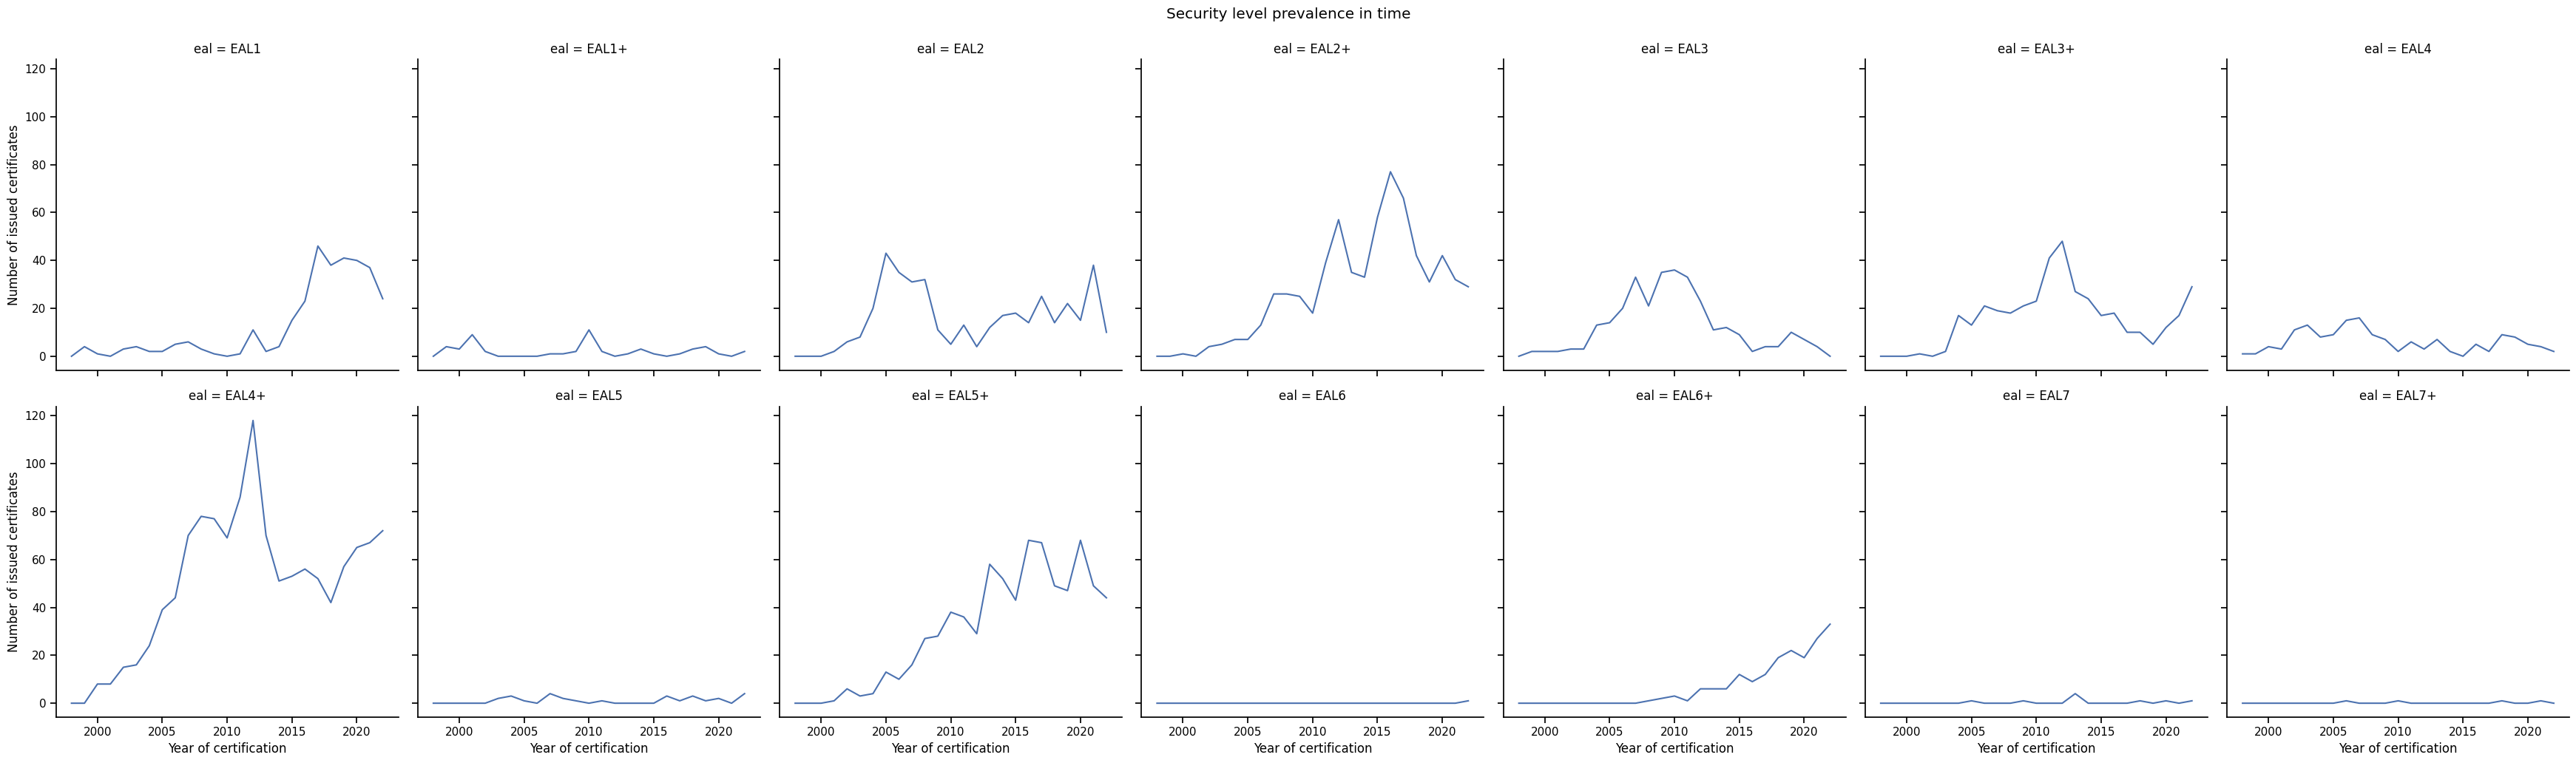

In [4]:
# Display EAL in time
sec_levels = cc_df.loc[cc_df.year_from < 2023].groupby(["year_from", "eal"], as_index=False).size()
plt.figure()
g = sns.relplot(data=sec_levels, x="year_from", y="size", col="eal", kind="line", col_wrap=7)
g.set(xlabel="Year of certification", ylabel="Number of issued certificates")
g.fig.suptitle("Security level prevalence in time", y=1.03)
g.fig.savefig(RESULTS_DIR / "sec_levels_in_time.pdf", bbox_inches="tight")
g.fig.show()

## Compute category summary

In [28]:
def simplified_category_mapping(cat) -> str:
    if cat in CARD_RELATED_CAT:
        return "Smartcard-related"
    elif cat in OTHERS_CAT:
        return "Others"
    elif cat == SMARTCARD_CATEGORY:
        return "Smartcards"
    else:
        raise ValueError(f"Unknown category {cat}")


cc_df_comp["category_simplified"] = cc_df_comp.category.map(simplified_category_mapping)
cc_df_prev["category_simplified"] = cc_df_prev.category.map(simplified_category_mapping)

component_reuse = cc_df_comp.groupby("category_simplified").n_refs.sum().rename("Component reuse")
previous_version = cc_df_prev.groupby("category_simplified").n_refs.sum().rename("Predecessor")

pd.DataFrame([component_reuse, previous_version]).transpose().rename_axis("Product category").to_csv(
    RESULTS_DIR / "ref_categories_stackplot.csv"
)

### Count numbers of reference-rich certificates

Total number of referencing certificates: 1952 (36.19%)
Number of smartcard certificates that reference some other certificate: 1461 (83.58%)
	- Out of that, 1307 do reference a sub-component.
	- Out of that, 551 do reference a previous version.
Number of non-smartcard certificates that reference some other certificate: 491 (13.47%)
	- Out of that, 280 do reference a sub-component.
	- Out of that, 313 do reference a previous version.
Note that the numbers don't sum to 100, as a certificate can reference both a sub-component and a previous version.


{}

<Figure size 640x480 with 0 Axes>

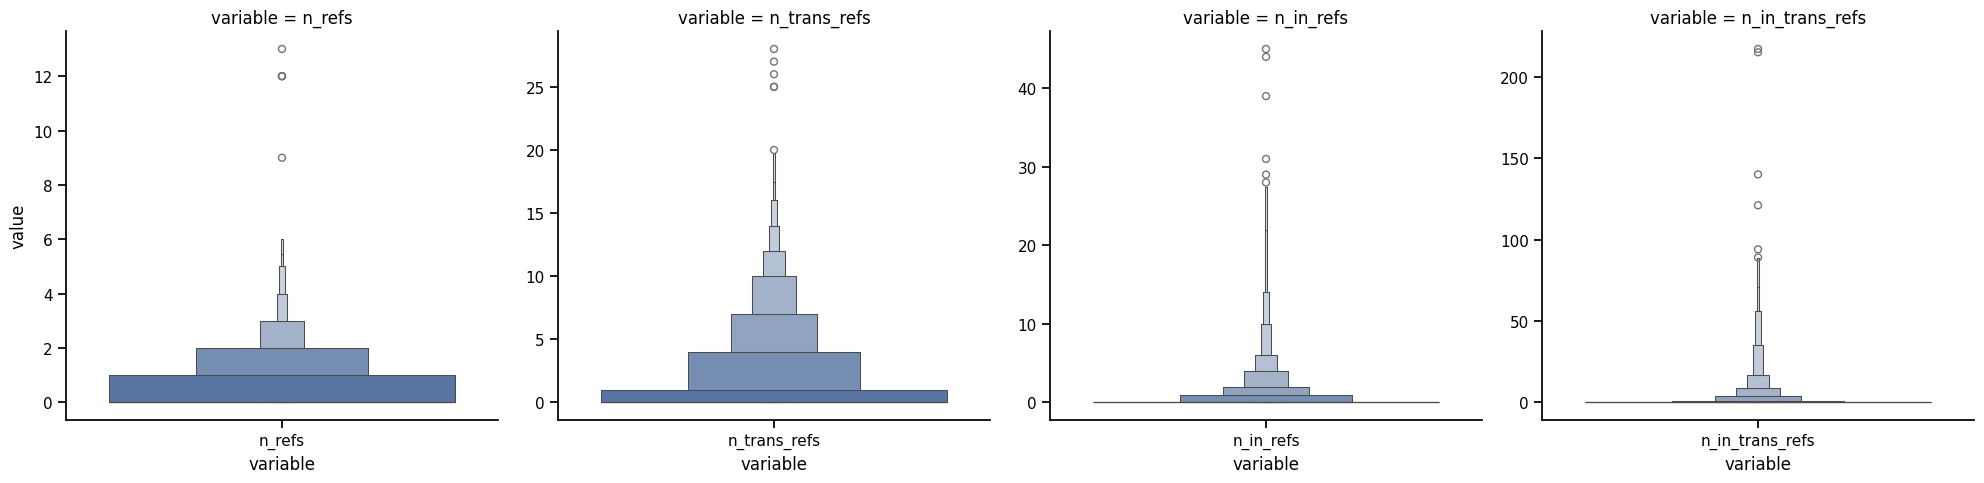

In [5]:
def compute_basic_reference_graph_stats(
    df__: pd.DataFrame, df_comp__: pd.DataFrame, df_prev__: pd.DataFrame
) -> dict[str, str]:
    df = df__.copy().assign(has_refs=lambda df_: df_.refs.notnull())
    df_comp = df_comp__.copy().assign(has_refs=lambda df_: df_.refs.notnull())
    df_prev = df_prev__.copy().assign(has_refs=lambda df_: df_.refs.notnull())

    n_ref_smartcards = df.loc[(df.has_refs) & (df.category == SMARTCARD_CATEGORY)].shape[0]
    n_ref_others = df.loc[(df.has_refs) & (df.category != SMARTCARD_CATEGORY)].shape[0]

    n_comp_smartcards = df_comp.loc[(df_comp.category == SMARTCARD_CATEGORY) & (df_comp.has_refs)].shape[0]
    n_comp_others = df_comp.loc[(df_comp.category != SMARTCARD_CATEGORY) & (df_comp.has_refs)].shape[0]

    n_prev_smartcards = df_prev.loc[(df_prev.category == SMARTCARD_CATEGORY) & (df_prev.has_refs)].shape[0]
    n_prev_others = df_prev.loc[(df_prev.category != SMARTCARD_CATEGORY) & (df_prev.has_refs)].shape[0]

    print(
        f"Total number of referencing certificates: {n_ref_smartcards + n_ref_others} ({100 * (n_ref_smartcards + n_ref_others) / df.shape[0]:.2f}%)"
    )
    print(
        f"Number of smartcard certificates that reference some other certificate: {n_ref_smartcards} ({100 * n_ref_smartcards / df.loc[df.category == SMARTCARD_CATEGORY].shape[0]:.2f}%)"
    )
    print(f"\t- Out of that, {n_comp_smartcards} do reference a sub-component.")
    print(f"\t- Out of that, {n_prev_smartcards} do reference a previous version.")
    print(
        f"Number of non-smartcard certificates that reference some other certificate: {n_ref_others} ({100 * n_ref_others / df.loc[df.category != SMARTCARD_CATEGORY].shape[0]:.2f}%)"
    )
    print(f"\t- Out of that, {n_comp_others} do reference a sub-component.")
    print(f"\t- Out of that, {n_prev_others} do reference a previous version.")
    print(
        "Note that the numbers don't sum to 100, as a certificate can reference both a sub-component and a previous version."
    )

    df_melted = df[["n_refs", "n_trans_refs", "n_in_refs", "n_in_trans_refs"]].melt()
    df_melted["incoming"] = df_melted.variable.map(lambda x: bool(x.endswith("by")))
    plt.figure()
    g = sns.catplot(data=df_melted, kind="boxen", x="variable", y="value", col="variable", sharex=False, sharey=False)
    g.fig.savefig(RESULTS_DIR / "boxen_plot_references.pdf", bbox_inches="tight")
    g.fig.show()

    return {}


compute_basic_reference_graph_stats(cc_df, cc_df_comp, cc_df_prev)

## Evolution of certificate reach for top-10 certificates

                               cert_id  n_in_trans_refs
dgst                                                   
dd000f356b48904d  BSI-DSZ-CC-0813-2012               77
d12cc4580cb099f8      ANSSI-CC-2009/05               64
a4d0e44f4527180f      ANSSI-CC-2009/06               63
5cdef03a3004a6ff      ANSSI-CC-2009/26               62
2d2ce200fea72359      ANSSI-CC-2009/28               57
Infineon smart card IC (Security Controller) M7820 A11 with optional RSA2048/4096 v1.02.008, EC v1.02.008, SHA-2 v1.01 and Toolbox v1.02.008 libraries and with specific IC dedicated software
Secured Microcontroller ST23YR80A
Secured Microcontrollers SA23YR80A including the cryptographic Library NesLib SA revision 1.0
STMicroelectronics ST23YR48A Secure Microcontroller
STMicroelectronics SB23YR80A Secure Microcontroller, including the cryptographic library Neslib v2.0 SB


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:26<00:00,  5.25s/it]


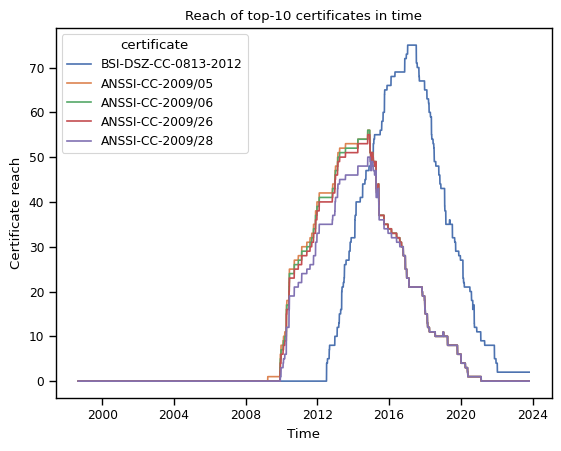

In [29]:
# TODO: Decide on and implement the note below
"""
This implementation is naive. When computing on full graph, RoCA vulnerable certs. are the most popular. They are re-evaluated bunch of times. On top of that, each iteration is referendec by
a decent number of certificates in a sub-compoennt relationship.
The product is not a single certificate, but rather a chain of n-times re-evaluated certificates. In order to capture the true number of sub-component references, I'd need to sum the references in all the iterations (for each re-evaluation).
"""


def compute_certs_top_reach(df__: pd.DataFrame):
    df = df__.copy()
    top_10_certs = df.sort_values(by="n_in_trans_refs", ascending=False).head(5)
    print(top_10_certs[["cert_id", "n_in_trans_refs"]])
    for dgst in top_10_certs.index.tolist():
        print(dset[dgst].name)

    date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())
    data = [find_reach_over_time(df, x, date_range) for x in tqdm(top_10_certs.cert_id.tolist())]
    df_reach_evolution_melted = (
        pd.concat(data, axis=1)
        .rename_axis("date")
        .reset_index()
        .melt(id_vars="date", var_name="certificate", value_name="reach")
    )

    plt.figure()
    g = sns.lineplot(data=df_reach_evolution_melted, x="date", y="reach", hue="certificate")
    g.set(title="Reach of top-10 certificates in time", xlabel="Time", ylabel="Certificate reach")
    g.figure.savefig(RESULTS_DIR / "lineplot_top_certificate_reach.pdf", bbox_inches="tight")
    g.figure.show()

    return top_10_certs.index.tolist(), df_reach_evolution_melted


top_10_digests, df_to_plot = compute_certs_top_reach(cc_df_comp)
df_to_plot.to_csv(RESULTS_DIR / "average_reach_over_time.csv", header=True, index=False)

## Combined reach evolution in time

100%|██████████| 9056/9056 [00:54<00:00, 165.33it/s]


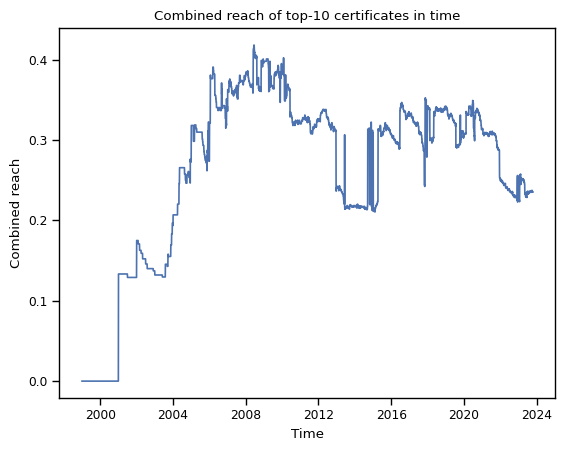

In [69]:
df = cc_df_comp.loc[cc_df_comp.category == SMARTCARD_CATEGORY]
date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())
cert_ids_with_reach = df.loc[df.n_in_trans_refs > 0]

dct = {}
for date in tqdm(date_range):
    active_certs = df.loc[(date >= df.not_valid_before) & (date <= df.not_valid_after)]
    active_cert_ids = set(active_certs.cert_id)
    daily_certs_with_reach = cert_ids_with_reach.assign(
        in_trans_refs=lambda df_: df_.in_trans_refs.apply(lambda x: x.intersection(active_cert_ids)),
        n_in_trans_refs=lambda df_: df_.in_trans_refs.map(len_if_exists),
    )
    daily_top_10 = daily_certs_with_reach.sort_values(by="n_in_trans_refs", ascending=False).head(10)
    dct[date] = len(set(itertools.chain.from_iterable(daily_top_10.in_trans_refs.tolist()))) / len(active_cert_ids)

reach_df = pd.DataFrame(pd.Series(dct, name="combined reach")).rename_axis("date")

plt.figure()
g = sns.lineplot(data=reach_df, x="date", y="combined reach")
g.set(title="Combined reach of top-10 certificates in time", xlabel="Time", ylabel="Combined reach")
g.figure.savefig(RESULTS_DIR / "combined_reach_evolution.pdf", bbox_inches="tight")
g.figure.show()

## Average number of references & certificate reach over time

In [59]:
def compute_avg_references(df__: pd.DataFrame, variable: str, date_range: pd.DatetimeIndex) -> dict:
    df = df__.copy()
    return {
        date: df.loc[(date >= df.not_valid_before) & (date <= df.not_valid_after)][variable].mean()
        for date in tqdm(date_range)
    }


def compute_avg_reach(df__: pd.DataFrame, categories: set[str], date_range: pd.DatetimeIndex) -> dict:
    certs_from_category = df__.copy().loc[df__.category.isin(categories)]
    certs_with_reach = certs_from_category.loc[certs_from_category.n_in_trans_refs > 0].cert_id.tolist()

    print("Preparing inputs for average reach computation...")
    parallel_processing_inputs = [(df__.copy(), x, date_range) for x in certs_with_reach]
    print("Computing average reach in parallel...")
    outputs = process_parallel(
        find_reach_over_time, parallel_processing_inputs, max_workers=200, use_threading=False, unpack=True
    )
    reach_dict = dict(zip(certs_with_reach, outputs))

    averages = {}
    for date in date_range:
        averages[date] = np.mean([reach_dict[x][date] for x in reach_dict])

    return averages


def compute_avg_references_over_time(df__: pd.DataFrame) -> dict:
    df = df__.copy()
    date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())
    refs_smartcards = compute_avg_references(df.loc[df.category == SMARTCARD_CATEGORY], "n_refs", date_range)
    trans_refs_smartcards = compute_avg_references(
        df.loc[df.category == SMARTCARD_CATEGORY], "n_trans_refs", date_range
    )
    refs_others = compute_avg_references(df.loc[df.category != SMARTCARD_CATEGORY], "n_refs", date_range)
    trans_refs_others = compute_avg_references(df.loc[df.category != SMARTCARD_CATEGORY], "n_trans_refs", date_range)

    df_avg_num_refs_melted = (
        pd.concat(
            [
                pd.Series(refs_smartcards, name="smartcard references"),
                pd.Series(refs_others, name="other references"),
                pd.Series(trans_refs_smartcards, name="smartcard transitive references"),
                pd.Series(trans_refs_others, name="other transitive references"),
            ],
            axis=1,
        )
        .rename_axis("date")
        .reset_index()
        .melt(id_vars=["date"], var_name="category", value_name="n_references")
    )

    plt.figure()
    fig = px.line(
        df_avg_num_refs_melted,
        x="date",
        y="n_references",
        color="category",
        hover_data={"date": "|%Y-%m-%d"},
        title="Timestamp vs Value",
    )
    fig.show()

    return {}


def compute_avg_reach_over_time(df__: pd.DataFrame) -> dict:
    df = df__.copy()
    date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())
    reach_smartcards = compute_avg_reach(df, {SMARTCARD_CATEGORY}, date_range)
    reach_card_related = compute_avg_reach(df, CARD_RELATED_CAT, date_range)
    reach_others = compute_avg_reach(df, OTHERS_CAT, date_range)

    df_avg_num_refs_melted = (
        pd.concat(
            [
                pd.Series(reach_smartcards, name="smartcards"),
                pd.Series(reach_card_related, name="smartcard-related"),
                pd.Series(reach_others, name="others"),
            ],
            axis=1,
        )
        .rename_axis("date")
        .reset_index()
        .melt(id_vars=["date"], var_name="category", value_name="n_references")
    )

    return df_avg_num_refs_melted


# compute_avg_references_over_time(cc_df_comp)
# df_avg_reach = compute_avg_reach_over_time(cc_df_comp)
# df_avg_reach.to_csv(RESULTS_DIR / "avg_reach_over_time.csv", header=True, index=False)

## Histogram of n days to 0-reach for certificates given they archival date

- For each certificate that has >0 reach on its archival date, we compute the number of days *after* the archival date such that its reach is >0
- We then plot the histogram of these numbers

100%|██████████| 652/652 [03:03<00:00,  3.55it/s]


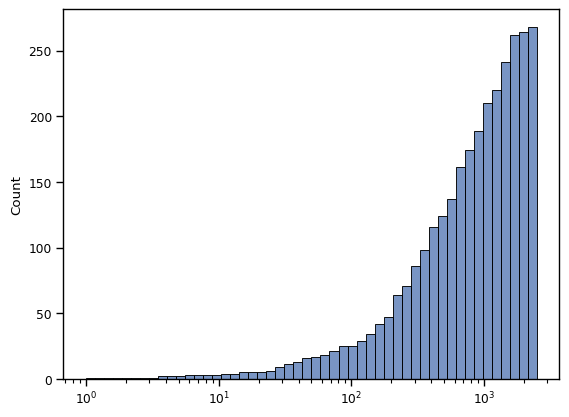

,0
count,268.000000
mean,707.380597
std,550.078827
min,1.000000
25%,252.000000
50%,596.500000
75%,1044.000000
max,2508.000000


In [52]:
date_range = pd.date_range(cc_df_comp.not_valid_before.min(), cc_df_comp.not_valid_before.max())
cert_ids_with_reach = list(set(cc_df_comp.loc[cc_df_comp.n_in_trans_refs > 0].cert_id.tolist()))
parallel_processing_inputs = [(cc_df_comp.copy(), x, date_range) for x in cert_ids_with_reach]
reach_list = process_parallel(
    find_reach_over_time, parallel_processing_inputs, max_workers=200, use_threading=False, unpack=True
)
cert_id_to_archival = cc_df_comp[["cert_id", "not_valid_after"]].set_index("cert_id").to_dict()["not_valid_after"]

# Choose only rows that are post-archival and with >0 reach
reach_list = [x.loc[(x.index > cert_id_to_archival[x.name]) & (x > 0)] for x in reach_list]
# Pick the number of such rows
reach_list = [x.shape[0] for x in reach_list if x.shape[0] > 0]

# cc_df_comp.not_valid_after.value_counts()
sns.histplot(data=reach_list, log_scale=True, bins=50, cumulative=True)
plt.show()
pd.DataFrame(reach_list).describe()

pd.DataFrame(reach_list, columns=["n_days"]).to_csv(RESULTS_DIR / "archived_half_life.csv")

In [117]:
def plot_avg_references_over_time(df__: pd.DataFrame) -> dict:
    df = df__.copy()
    card_related_categories = {"Other Devices and Systems", "Products for Digital Signatures", "Trusted Computing"}
    other_categories = {
        "Access Control Devices and Systems",
        "Biometric Systems and Devices",
        "Boundary Protection Devices and Systems",
        "Data Protection",
        "Databases",
        "Detection Devices and Systems",
        "Key Management Systems",
        "Mobility",
        "Multi-Function Devices",
        "Network and Network-Related Devices and Systems",
        "Operating Systems",
    }
    date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())
    refs_smartcards = compute_avg_references(df.loc[df.category == SMARTCARD_CATEGORY], "n_trans_refs", date_range)
    refs_card_related = compute_avg_references(
        df.loc[df.category.isin(card_related_categories)], "n_trans_refs", date_range
    )
    refs_others = compute_avg_references(df.loc[df.category.isin(other_categories)], "n_trans_refs", date_range)

    df_avg_num_refs_melted = (
        pd.concat(
            [
                pd.Series(refs_smartcards, name="smartcards"),
                pd.Series(refs_card_related, name="smartcard-related"),
                pd.Series(refs_others, name="others categories"),
            ],
            axis=1,
        )
        .rename_axis("date")
        .reset_index()
        .melt(id_vars=["date"], var_name="category", value_name="n_references")
    )

    # plt.figure()
    # g = sns.lineplot(data=df_avg_num_refs_melted, x="date", y="n_references", hue="category", errorbar=None)
    # g.set(
    #     title="Average number of transitive references in time",
    #     xlabel="Time",
    #     ylabel="Number of certificates",
    # )
    # g.figure.savefig(RESULTS_DIR / "lineplot_avg_refs.pdf", bbox_inches="tight")
    # g.figure.show()

    return df_avg_num_refs_melted


df_to_plot = plot_avg_references_over_time(cc_df_comp)
df_to_plot.to_csv(RESULTS_DIR / "avg_refs_over_time.csv", header=True, index=False)

100%|██████████| 9185/9185 [00:08<00:00, 1072.00it/s]


## Number of active vs. number of reference-rich certificates in time

100%|██████████| 9185/9185 [00:20<00:00, 458.34it/s]


{}

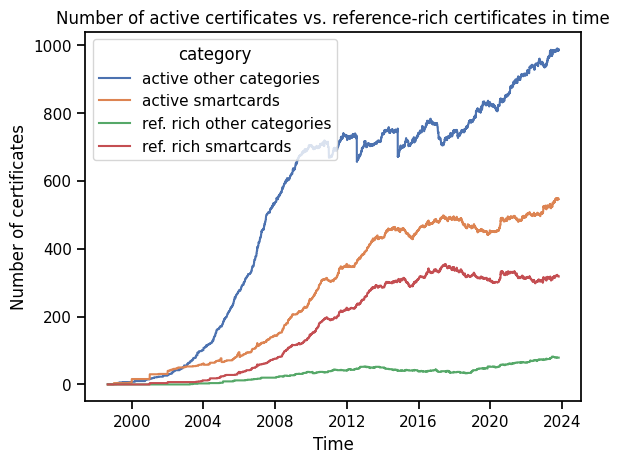

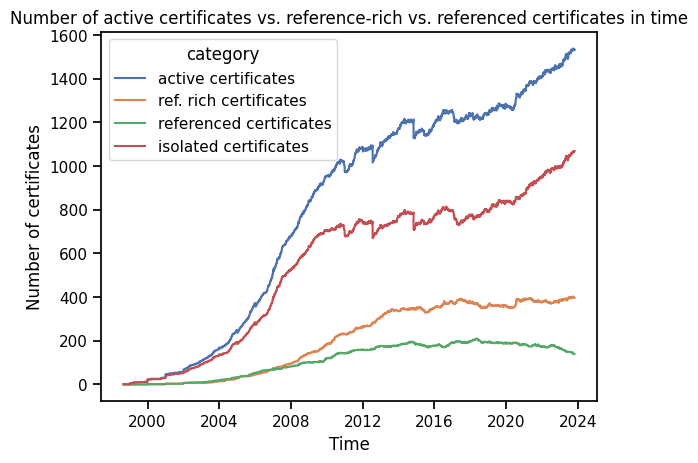

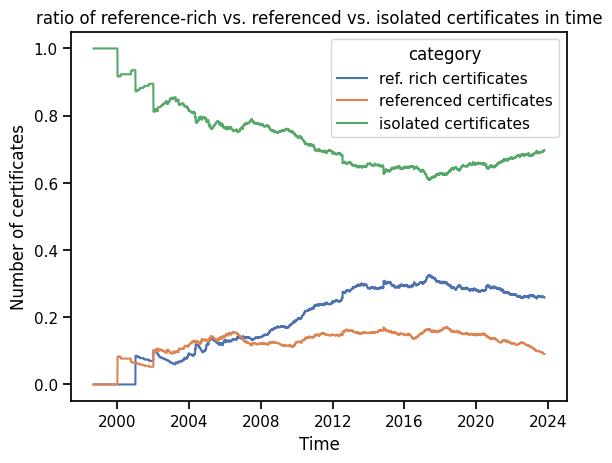

In [8]:
def compute_number_of_active_vs_ref_rich_certs_over_time(df__: pd.DataFrame) -> dict:
    df = df__.copy()
    date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())

    dct_active_others = {}
    dct_reference_rich_others = {}
    dct_active_smartcards = {}
    dct_reference_rich_smartcards = {}

    for date in tqdm(date_range):
        active_certs = df.loc[(date >= df.not_valid_before) & (date <= df.not_valid_after)]
        dct_active_others[date] = active_certs.loc[active_certs.category != SMARTCARD_CATEGORY].shape[0]
        dct_active_smartcards[date] = active_certs.loc[active_certs.category == SMARTCARD_CATEGORY].shape[0]
        dct_reference_rich_others[date] = active_certs.loc[
            (active_certs.category != SMARTCARD_CATEGORY) & (active_certs.n_refs > 0)
        ].shape[0]
        dct_reference_rich_smartcards[date] = active_certs.loc[
            (active_certs.category == SMARTCARD_CATEGORY) & (active_certs.n_refs > 0)
        ].shape[0]

    df_active_vs_ref_rich_melted = (
        pd.concat(
            [
                pd.Series(dct_active_others, name="active other categories"),
                pd.Series(dct_active_smartcards, name="active smartcards"),
                pd.Series(dct_reference_rich_others, name="ref. rich other categories"),
                pd.Series(dct_reference_rich_smartcards, name="ref. rich smartcards"),
            ],
            axis=1,
        )
        .rename_axis("date")
        .reset_index()
        .melt(id_vars=["date"], var_name="category", value_name="number of certificates")
    )

    plt.figure()
    g = sns.lineplot(data=df_active_vs_ref_rich_melted, x="date", y="number of certificates", hue="category")
    g.set(
        title="Number of active certificates vs. reference-rich certificates in time",
        xlabel="Time",
        ylabel="Number of certificates",
    )
    g.figure.savefig(RESULTS_DIR / "lienplot_n_active_certs_vs_n_references.pdf", bbox_inches="tight")
    g.figure.show()
    return {}


def compute_summary_active_vs_ref_rich_over_time(df__: pd.DataFrame) -> dict:
    df = df__.copy()
    date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())

    dct_active_all = {}
    dct_reference_rich_all = {}
    dct_referenced_all = {}
    dct_isolated_all = {}

    for date in tqdm(date_range):
        active_certs = df.loc[(date >= df.not_valid_before) & (date <= df.not_valid_after)]
        dct_active_all[date] = active_certs.shape[0]
        dct_isolated_all[date] = active_certs.loc[(active_certs.n_refs == 0) & (active_certs.n_in_refs == 0)].shape[0]
        dct_reference_rich_all[date] = active_certs.loc[active_certs.n_refs > 0].shape[0]
        dct_referenced_all[date] = active_certs.loc[active_certs.n_in_refs > 0].shape[0]

    df_summary_references = (
        pd.concat(
            [
                pd.Series(dct_active_all, name="active certificates"),
                pd.Series(dct_reference_rich_all, name="ref. rich certificates"),
                pd.Series(dct_referenced_all, name="referenced certificates"),
                pd.Series(dct_isolated_all, name="isolated certificates"),
            ],
            axis=1,
        )
        .rename_axis("date")
        .reset_index()
    )

    df_summary_references_melted = df_summary_references.melt(
        id_vars=["date"], var_name="category", value_name="number of certificates"
    )

    plt.figure()
    g = sns.lineplot(
        data=df_summary_references_melted, x="date", y="number of certificates", hue="category", errorbar=None
    )
    g.set(
        title="Number of active certificates vs. reference-rich vs. referenced certificates in time",
        xlabel="Time",
        ylabel="Number of certificates",
    )
    g.figure.savefig(RESULTS_DIR / "lineplot_references_summary.pdf", bbox_inches="tight")
    g.figure.show()

    df_ratios = df_summary_references.copy()
    df_ratios["ref. rich certificates"] = df_ratios["ref. rich certificates"] / df_ratios["active certificates"]
    df_ratios["referenced certificates"] = df_ratios["referenced certificates"] / df_ratios["active certificates"]
    df_ratios["isolated certificates"] = df_ratios["isolated certificates"] / df_ratios["active certificates"]
    df_ratios = df_ratios.drop(columns=["active certificates"])
    df_ratios_melted = df_ratios.melt(id_vars=["date"], var_name="category", value_name="ratio of certificates")

    plt.figure()
    g = sns.lineplot(data=df_ratios_melted, x="date", y="ratio of certificates", hue="category", errorbar=None)
    g.set(
        title="ratio of reference-rich vs. referenced vs. isolated certificates in time",
        xlabel="Time",
        ylabel="Number of certificates",
    )
    g.figure.savefig(RESULTS_DIR / "lineplot_reference_ratio.pdf", bbox_inches="tight")
    g.figure.show()

    return {}


compute_number_of_active_vs_ref_rich_certs_over_time(cc_df_comp)
compute_summary_active_vs_ref_rich_over_time(cc_df_comp)

## Number of active certificates that reference some archived certificate in time

100%|██████████| 9185/9185 [01:08<00:00, 134.03it/s]


{}

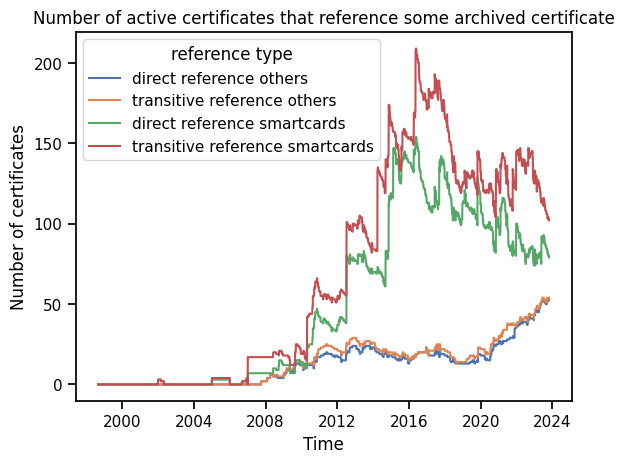

In [9]:
def compute_certs_referencing_archived_ones(df__: pd.DataFrame) -> dict:
    df = df__.copy()
    date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())

    dct_direct_others = {}
    dct_direct_smartcards = {}
    dct_transitive_others = {}
    dct_transitive_smartcards = {}

    for date in tqdm(date_range):
        active_certs = df.loc[(date >= df.not_valid_before) & (date <= df.not_valid_after)].copy()
        archived_certs = df.loc[(date < df.not_valid_before) | (date > df.not_valid_after)].copy()
        archived_cert_ids = set(archived_certs["cert_id"].tolist())
        active_certs["ref_archived"] = active_certs.refs.map(
            lambda x: False if pd.isnull(x) else bool(x.intersection(archived_cert_ids))
        )
        active_certs["trans_ref_archived"] = active_certs.trans_refs.map(
            lambda x: False if pd.isnull(x) else bool(x.intersection(archived_cert_ids))
        )

        dct_direct_others[date] = active_certs.loc[
            (active_certs.ref_archived) & (active_certs.category != SMARTCARD_CATEGORY)
        ].shape[0]
        dct_transitive_others[date] = active_certs.loc[
            (active_certs.trans_ref_archived) & (active_certs.category != SMARTCARD_CATEGORY)
        ].shape[0]
        dct_direct_smartcards[date] = active_certs.loc[
            (active_certs.ref_archived) & (active_certs.category == SMARTCARD_CATEGORY)
        ].shape[0]
        dct_transitive_smartcards[date] = active_certs.loc[
            (active_certs.trans_ref_archived) & (active_certs.category == SMARTCARD_CATEGORY)
        ].shape[0]

    df_refs_to_archived_melted = (
        pd.concat(
            [
                pd.Series(dct_direct_others, name="direct reference others"),
                pd.Series(dct_transitive_others, name="transitive reference others"),
                pd.Series(dct_direct_smartcards, name="direct reference smartcards"),
                pd.Series(dct_transitive_smartcards, name="transitive reference smartcards"),
            ],
            axis=1,
        )
        .rename_axis("date")
        .reset_index()
        .melt(id_vars=["date"], var_name="reference type", value_name="number of certificates")
    )

    plt.figure()
    g = sns.lineplot(data=df_refs_to_archived_melted, x="date", y="number of certificates", hue="reference type")
    g.set(
        title="Number of active certificates that reference some archived certificate",
        xlabel="Time",
        ylabel="Number of certificates",
    )
    g.figure.savefig(RESULTS_DIR / "lienplot_active_certs_referencing_archived.pdf", bbox_inches="tight")
    g.figure.show()

    return {}


compute_certs_referencing_archived_ones(cc_df_comp)

## Certificates referencing an archived certificate on their issuance day

In [12]:
def compute_refs_to_archived_on_issuance_day(cc_df_comp: pd.DataFrame, cc_dset: CCDataset) -> None:
    cert_id_to_dgst = {x.heuristics.cert_id: x.dgst for x in cc_dset}

    def cert_id_to_url(cert_id):
        return f"https://seccerts.org/cc/{cert_id_to_dgst[cert_id]}/"

    def cert_was_archived_on_date(date: pd.Timestamp, cert_id: str) -> bool:
        if not date:
            return False
        if not dset[cert_id_to_dgst[cert_id]].not_valid_after:
            return False
        return date.date() > dset[cert_id_to_dgst[cert_id]].not_valid_after

    df__ = cc_df_comp.copy()
    date_range = pd.date_range(df__.not_valid_before.min(), df__.not_valid_before.max())

    df_problematic = pd.DataFrame()
    for date in tqdm(date_range):
        certs_issued = df__.loc[(date == df__.not_valid_before) & (df__.n_refs > 0)].assign(
            refs_to_archived_certs=lambda df_: df_.refs.map(
                lambda refs: {x for x in refs if cert_was_archived_on_date(date, x)}
            )
        )
        df_problematic = pd.concat(
            [df_problematic, certs_issued[certs_issued.refs_to_archived_certs.map(lambda x: len(x) > 0)]]
        )

    df_problematic = df_problematic.assign(
        url=lambda df_: df_.cert_id.map(cert_id_to_url),
        archived_refs_urls=lambda df_: df_.refs_to_archived_certs.map(lambda x: [cert_id_to_url(y) for y in x]),
    )

    df_problematic = df_problematic[
        [
            "cert_id",
            "url",
            "name",
            "status",
            "category",
            "manufacturer",
            "scheme",
            "eal",
            "not_valid_before",
            "not_valid_after",
            "cert_lab",
            "refs",
            "refs_to_archived_certs",
            "archived_refs_urls",
        ]
    ]
    df_problematic.to_csv(RESULTS_DIR / "certs_with_refs_to_archived_on_their_issuance_date.csv", sep=";", index=False)

    return df_problematic


df_problematic = compute_refs_to_archived_on_issuance_day(cc_df_comp, dset)
n_refs_to_archived_when_issued = df_problematic.shape[0]

  7%|▋         | 611/9185 [00:01<00:13, 613.85it/s]

100%|██████████| 9185/9185 [00:12<00:00, 709.44it/s]


## Certificates referencing vulnerable certificates in time

100%|██████████| 9185/9185 [00:44<00:00, 206.89it/s]


{}

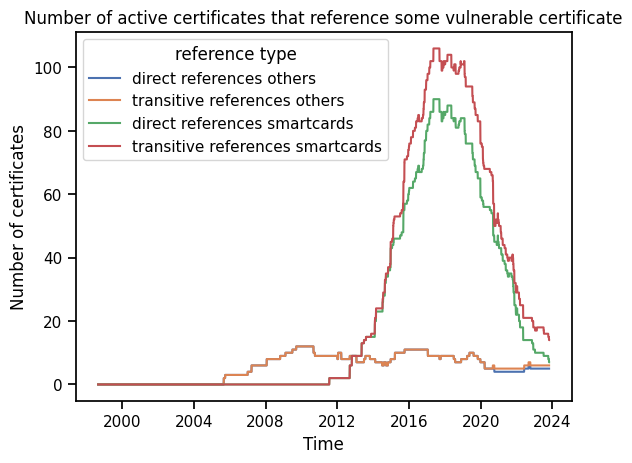

In [11]:
def compute_certs_referencing_vulnerable_over_time(df__: pd.DataFrame) -> dict:
    df = df__.copy()
    date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())
    vulnerable_cert_ids = set(df.loc[df.related_cves.notnull()].cert_id.tolist())
    dct_direct_others = {}
    dct_transitive_others = {}
    dct_direct_smartcards = {}
    dct_transitive_smartcards = {}

    for date in tqdm(date_range):
        active_certs = df.loc[(date >= df.not_valid_before) & (date <= df.not_valid_after)].copy()
        active_certs["directly_references_vulnerable_cert"] = active_certs.refs.map(
            lambda x: False if pd.isnull(x) else bool(x.intersection(vulnerable_cert_ids))
        )
        active_certs["transitively_references_vulnerable_cert"] = active_certs.trans_refs.map(
            lambda x: False if pd.isnull(x) else bool(x.intersection(vulnerable_cert_ids))
        )
        dct_direct_others[date] = active_certs.loc[
            (active_certs.directly_references_vulnerable_cert) & (active_certs.category != SMARTCARD_CATEGORY)
        ].shape[0]
        dct_transitive_others[date] = active_certs.loc[
            (active_certs.transitively_references_vulnerable_cert) & (active_certs.category != SMARTCARD_CATEGORY)
        ].shape[0]
        dct_direct_smartcards[date] = active_certs.loc[
            (active_certs.directly_references_vulnerable_cert) & (active_certs.category == SMARTCARD_CATEGORY)
        ].shape[0]
        dct_transitive_smartcards[date] = active_certs.loc[
            (active_certs.transitively_references_vulnerable_cert) & (active_certs.category == SMARTCARD_CATEGORY)
        ].shape[0]

    df_references_vuln_melted = (
        pd.concat(
            [
                pd.Series(dct_direct_others, name="direct references others"),
                pd.Series(dct_transitive_others, name="transitive references others"),
                pd.Series(dct_direct_smartcards, name="direct references smartcards"),
                pd.Series(dct_transitive_smartcards, name="transitive references smartcards"),
            ],
            axis=1,
        )
        .rename_axis("date")
        .reset_index()
        .melt(id_vars=["date"], var_name="reference type", value_name="number of certificates")
    )

    plt.figure()
    g = sns.lineplot(data=df_references_vuln_melted, x="date", y="number of certificates", hue="reference type")
    g.set(
        title="Number of active certificates that reference some vulnerable certificate",
        xlabel="Time",
        ylabel="Number of certificates",
    )
    g.figure.savefig(RESULTS_DIR / "lienplot_active_certs_referencing_vulnerable.pdf", bbox_inches="tight")
    g.figure.show()
    return {}


compute_certs_referencing_vulnerable_over_time(cc_df_comp)

## Certificates with sub-component reference to lower EAL cert

In [12]:
def compute_references_to_weaker_eals(cc_df_comp: pd.DataFrame, cc_dset: CCDataset) -> None:
    eal_to_rank = {category: index for index, category in enumerate(cc_df_comp.eal.dtype.categories)}
    cert_id_to_dst_mapping = {x.heuristics.cert_id: x.dgst for x in dset}

    def ref_is_weaker(cert_id: str, eal: str, ref_cert_id: str) -> bool:
        eal_rank = eal_to_rank[eal]
        ref_eal = dset[cert_id_to_dst_mapping[ref_cert_id]].eal
        ref_eal_rank = eal_to_rank[ref_eal]
        return ref_eal_rank < eal_rank

    df_ = cc_df_comp.copy()
    df_ = (
        df_.loc[
            (df_.n_refs > 0) & (df_.eal.notnull()),
            [
                "cert_id",
                "name",
                "status",
                "category",
                "manufacturer",
                "scheme",
                "eal",
                "not_valid_before",
                "not_valid_after",
                "refs",
            ],
        ]
        .assign(
            refs=lambda df__: df__.apply(
                lambda row: {x for x in row.refs if ref_is_weaker(row.cert_id, row.eal, x)}, axis=1
            ),
            n_refs=lambda df__: df__.refs.map(len_if_exists),
            referenced_levels=lambda df__: df__.refs.map(
                lambda x: {dset[cert_id_to_dst_mapping[y]].eal for y in x} if pd.notnull(x) else set()
            ),
        )
        .loc[lambda df__: df__.n_refs > 0]
    )

    df_.to_csv(RESULTS_DIR / "certs_referencing_weaker_eals.csv", index=False, sep=";")


compute_references_to_weaker_eals(cc_df_comp, dset)

### Plot direct references per category (count plot)

Countplot of sub-component references


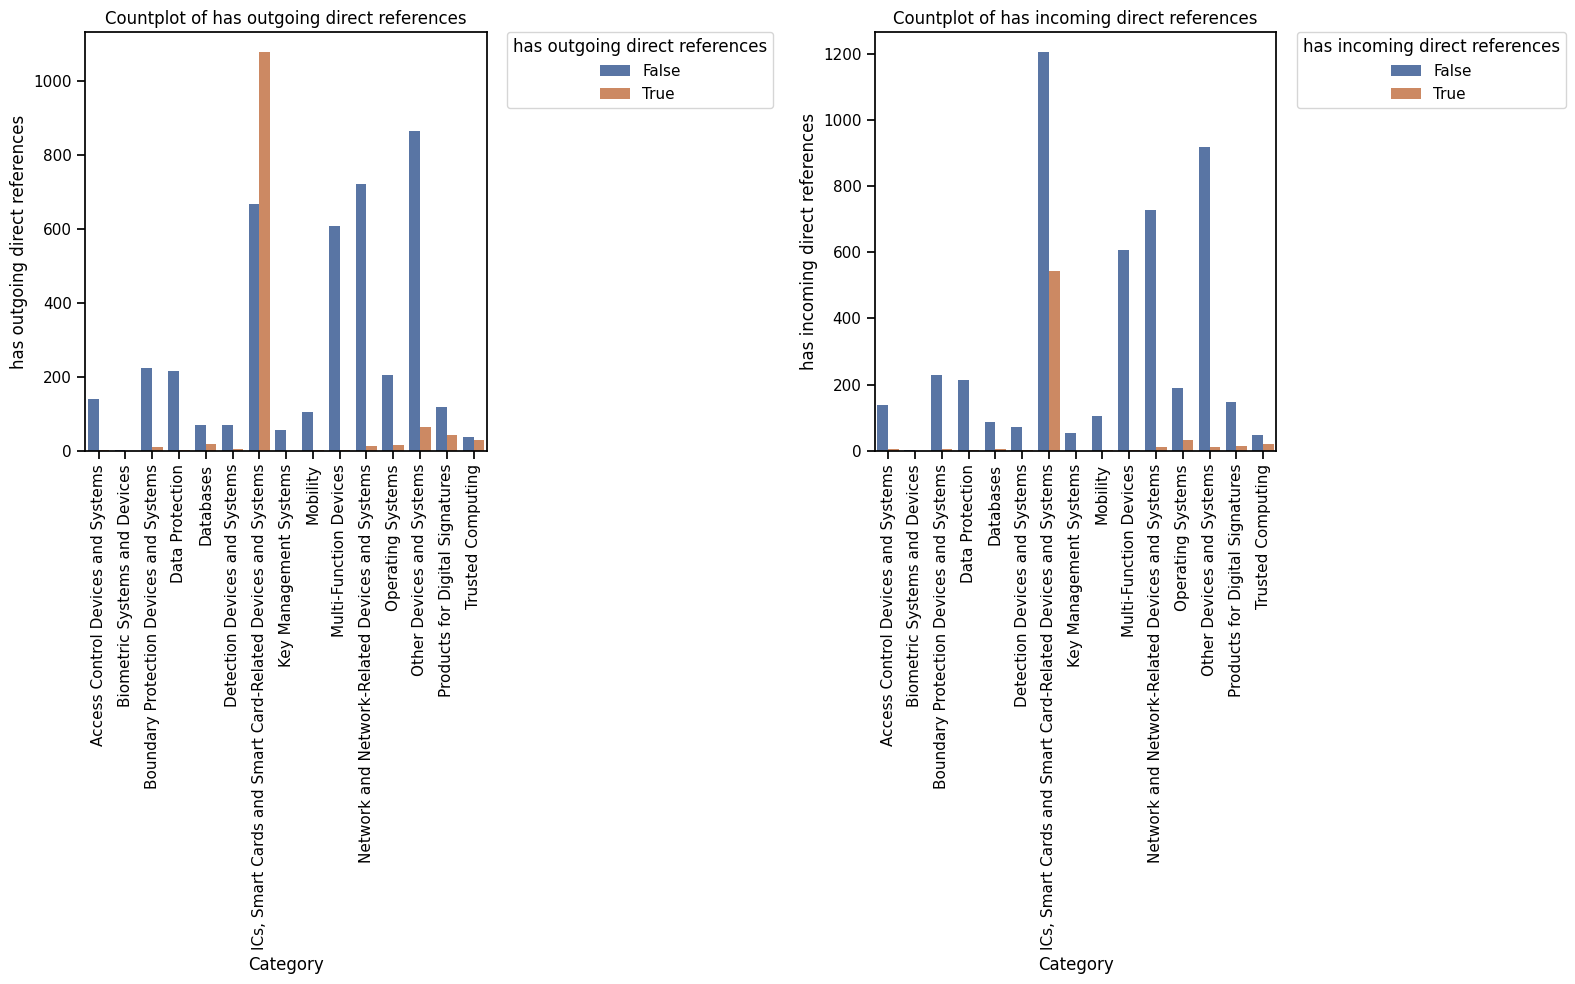

Countplot of previous version references


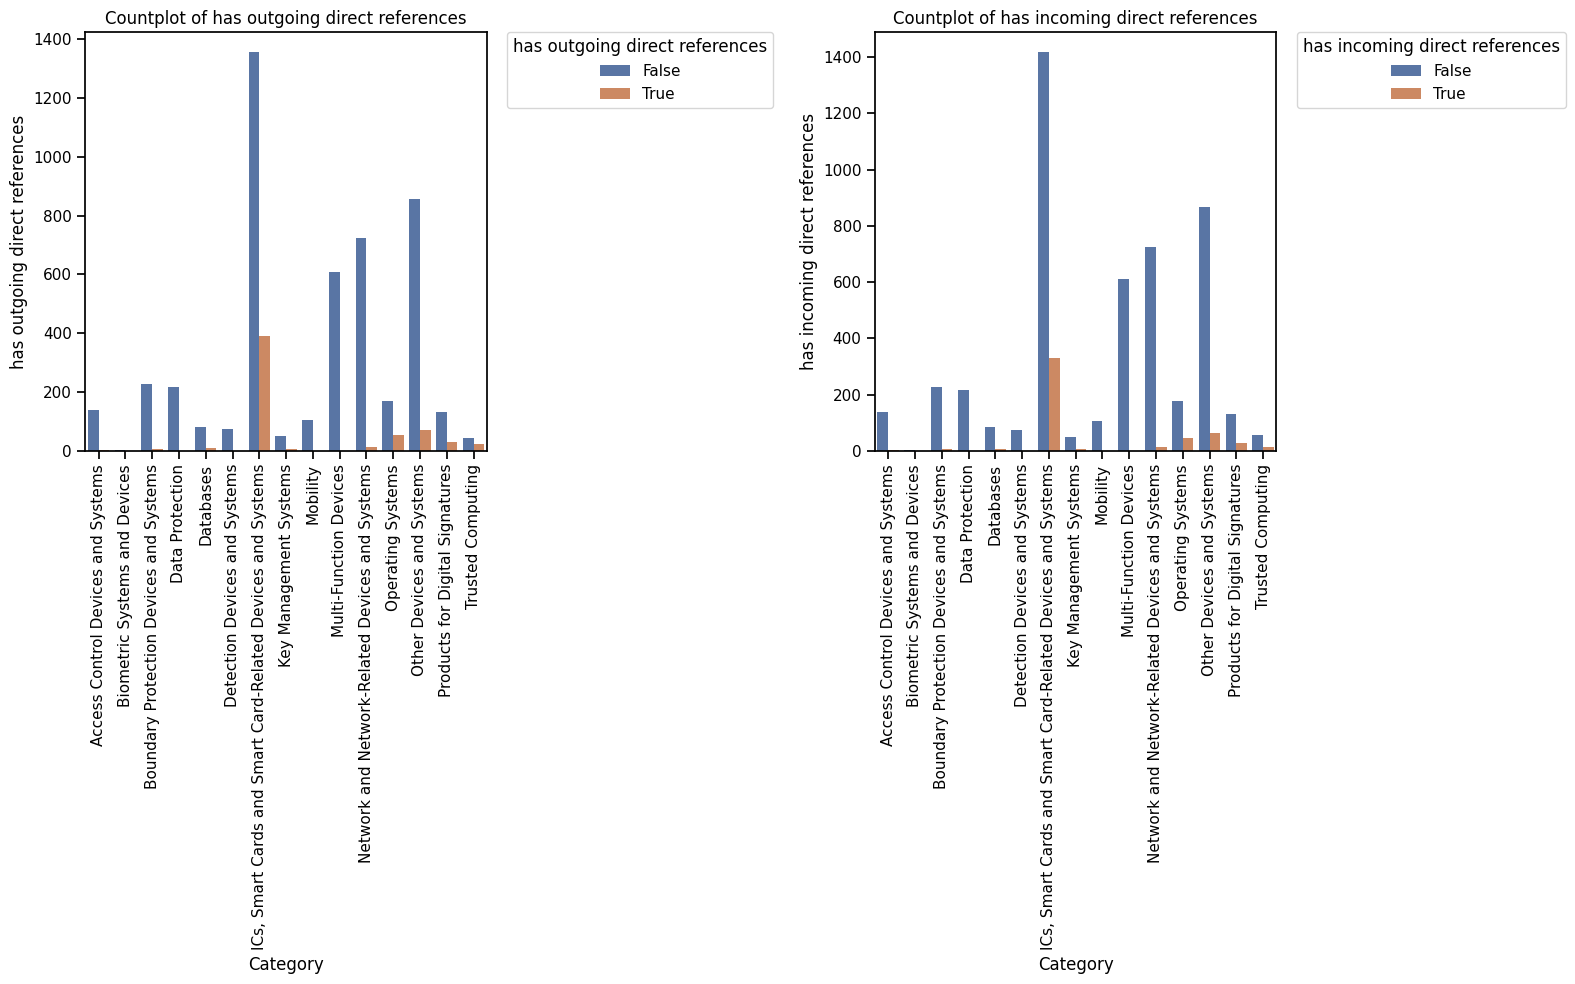

{}

In [13]:
def plot_direct_refs_per_category(df__: pd.DataFrame) -> dict:
    df = df__.copy().assign(
        has_outgoing_direct_references=lambda df_: df_.n_refs > 0,
        has_incoming_direct_references=lambda df_: df_.n_in_refs > 0,
    )
    figure, axes = plt.subplots(1, 2)
    figure.set_size_inches(16, 10)
    figure.set_tight_layout(True)

    col_to_depict = ["has_outgoing_direct_references", "has_incoming_direct_references"]

    for index, col in enumerate(col_to_depict):
        countplot = sns.countplot(data=df, x="category", hue=col, ax=axes[index])
        countplot.set(
            xlabel="Category",
            ylabel=f"{' '.join(col.split('_'))}",
            title=f"Countplot of {' '.join(col.split('_'))}",
        )
        countplot.tick_params(axis="x", rotation=90)
        countplot.legend(title=" ".join(col.split("_")), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    plt.show()

    return {}


print("Countplot of sub-component references")
plot_direct_refs_per_category(cc_df_comp)
print("Countplot of previous version references")
plot_direct_refs_per_category(cc_df_prev)

### Plot direct references per category (Sankey diagram)

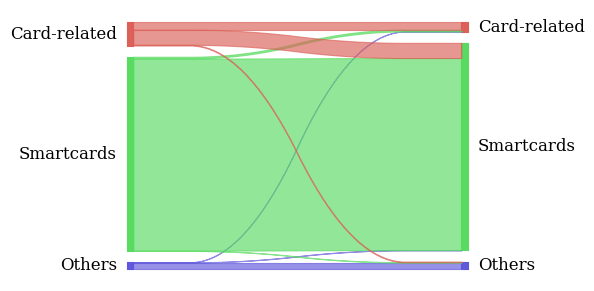

<Figure size 640x480 with 0 Axes>

{}

In [75]:
def plot_sankey_refs_categories(df__: pd.DataFrame) -> dict:
    def map_category(cat):
        if cat == SMARTCARD_CATEGORY:
            return "Smartcards"
        elif cat in CARD_RELATED_CAT:
            return "Card-related"
        else:
            return "Others"

    df = df__.copy().assign(category=lambda df_: df_.category.map(map_category))

    cert_id_to_category_mapping = dict(zip(df.cert_id, df.category))
    cert_id_to_category_mapping[np.NaN] = "No references"

    exploded = df.loc[:, ["category", "trans_refs"]].explode("trans_refs")
    exploded["ref_category"] = exploded.trans_refs.map(
        lambda x: cert_id_to_category_mapping[x] if pd.notnull(x) else np.nan
    )
    exploded = exploded.loc[exploded.ref_category.notnull()]

    exploded_with_refs = exploded.loc[exploded.ref_category != "No references"]

    all_categories = set(exploded.category.unique()) | set(exploded.ref_category.unique())
    colors = list(sns.color_palette("hls", len(all_categories), as_cmap=False).as_hex())
    color_dict = dict(zip(all_categories, colors))

    figure, axes = plt.subplots(1, 1)
    figure.set_size_inches(6, 3)
    figure.set_tight_layout(True)

    plt.figure()
    sankey(
        exploded.category,
        exploded.ref_category,
        colorDict=color_dict,
        leftLabels=list(exploded.category.unique()),
        rightLabels=list(exploded.ref_category.unique()),
        fontsize=12,
        ax=axes,
    )

    plt.show()

    return {}


plot_sankey_refs_categories(cc_df_comp)

### Plot direct references per scheme (count plot)

<Figure size 640x480 with 0 Axes>

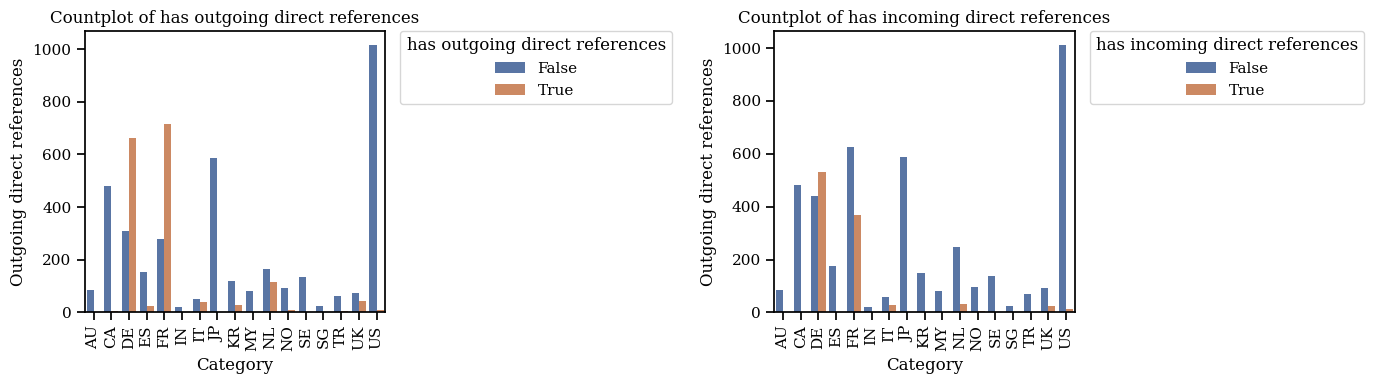

{}

In [15]:
def plot_refs_per_scheme(df__: pd.DataFrame) -> dict:
    df = df__.copy().assign(
        has_outgoing_direct_references=lambda df_: df_.n_refs > 0,
        has_incoming_direct_references=lambda df_: df_.n_in_refs > 0,
    )
    plt.figure()
    figure, axes = plt.subplots(1, 2)
    figure.set_size_inches(14, 4)
    figure.set_tight_layout(True)

    col_to_depict = ["has_outgoing_direct_references", "has_incoming_direct_references"]

    for index, col in enumerate(col_to_depict):
        countplot = sns.countplot(data=df, x="scheme", hue=col, ax=axes[index])
        countplot.set(
            xlabel="Category",
            ylabel="Outgoing direct references",
            title=f"Countplot of {' '.join(col.split('_'))}",
        )
        countplot.tick_params(axis="x", rotation=90)
        countplot.legend(title=" ".join(col.split("_")), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    plt.show()

    return {}


plot_refs_per_scheme(cc_df)

### Number of certificates referencing archived certificates (count plot)

100%|██████████| 9185/9185 [00:42<00:00, 218.30it/s]


Number of certificates that reference some archived certificate: 976


<Figure size 640x480 with 0 Axes>

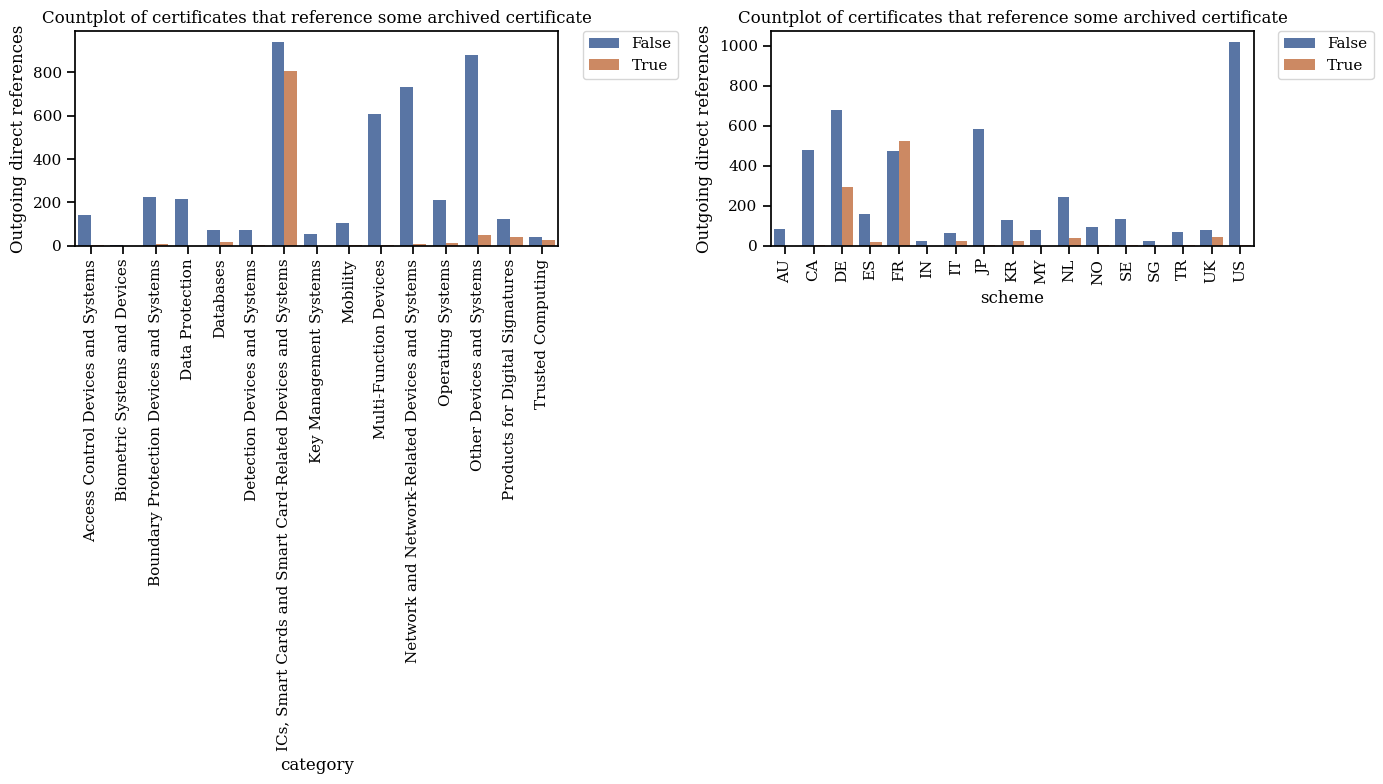

{}

In [16]:
def compute_certs_referencing_archived_ones(df__: pd.DataFrame) -> dict:
    df = df__.copy()
    date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())
    certs_that_reference_archived_one = set()

    for date in tqdm(date_range):
        active_certs = df.loc[(date >= df.not_valid_before) & (date <= df.not_valid_after)].copy()
        archived_certs = df.loc[(date < df.not_valid_before) | (date > df.not_valid_after)].copy()
        archived_cert_ids = set(archived_certs["cert_id"].tolist())
        active_certs["refs_archived"] = active_certs.refs.map(
            lambda x: False if pd.isnull(x) else bool(x.intersection(archived_cert_ids))
        )
        certs_that_reference_archived_one.update(active_certs.loc[(active_certs.refs_archived)].index.tolist())

    df["references_archived_cert"] = df.index.map(lambda x: x in certs_that_reference_archived_one)

    print(
        f"Number of certificates that reference some archived certificate: {df.loc[df.references_archived_cert].shape[0]}"
    )

    col_to_depict = ["category", "scheme"]

    plt.figure()
    figure, axes = plt.subplots(1, 2)
    figure.set_size_inches(14, 8)
    figure.set_tight_layout(True)

    for index, col in enumerate(col_to_depict):
        countplot = sns.countplot(data=df, x=col, hue="references_archived_cert", ax=axes[index])
        countplot.set(
            xlabel=col,
            ylabel="Outgoing direct references",
            title="Countplot of certificates that reference some archived certificate",
        )
        countplot.tick_params(axis="x", rotation=90)
        countplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    plt.show()

    return {}


compute_certs_referencing_archived_ones(cc_df_comp)

### Count scheme references (Sankey diagram)

RuntimeError: 'xelatex' not found; install it or change rcParams['pgf.texsystem'] to an available TeX implementation

<Figure size 640x480 with 0 Axes>

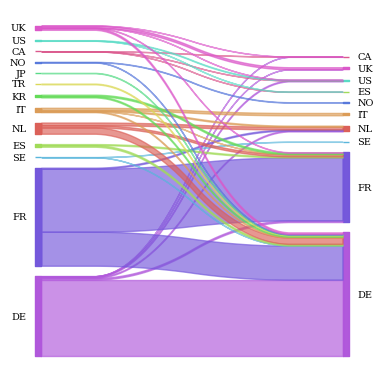

In [17]:
def plot_sankey_refs_schemes(df__: pd.DataFrame) -> dict:
    cert_id_to_scheme_mapping = dict(zip(df__.cert_id, df__.scheme))
    exploded = (
        df__.copy()
        .loc[lambda df_: df_.refs.notnull(), ["scheme", "refs"]]
        .explode("refs")
        .assign(ref_scheme=lambda df_: df_.refs.map(cert_id_to_scheme_mapping))
        .loc[lambda df_: df_.ref_scheme.notnull()]
    )

    all_schemes = set(exploded.scheme.unique()) | set(exploded.ref_scheme.unique())
    colors = list(sns.color_palette("hls", len(all_schemes), as_cmap=False).as_hex())
    color_dict = dict(zip(all_schemes, colors))

    plt.figure()
    figure, axes = plt.subplots(1, 1)
    figure.set_size_inches(4, 4)
    figure.set_tight_layout(True)

    sankey(
        exploded.scheme,
        exploded.ref_scheme,
        colorDict=color_dict,
        leftLabels=list(exploded.scheme.unique()),
        rightLabels=list(exploded.ref_scheme.unique()),
        fontsize=7,
        ax=axes,
    )

    figure.savefig(str(RESULTS_DIR / "scheme_references.pdf"), bbox_inches="tight")
    figure.savefig(str(RESULTS_DIR / "scheme_references.pgf"), bbox_inches="tight")
    plt.show()

    return {}


plot_sankey_refs_schemes(cc_df)

## Re-evaluation popularity

- How many certificates do undergo re-evaluation?
- How many rounds of re-evaluation do certificates undergo?
- How often (timewise) do these certificates undergo re-evaluation?

In [ ]:
def plot_ref_label_popularity_over_time(df__: pd.DataFrame, cc_df_comp__: pd.DataFrame, cc_df_prev__: pd.DataFrame):
    df = df__.copy()
    date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())
    sub_comp_refs = {}
    prev_refs = {}
    active_certs_dct = {}
    for date in tqdm(date_range):
        active_sub_comp_certs = cc_df_comp__.loc[
            (date >= cc_df_comp__.not_valid_before) & (date <= cc_df_comp__.not_valid_after)
        ].copy()
        active_prev_certs = cc_df_prev__.loc[
            (date >= cc_df_prev__.not_valid_before) & (date <= cc_df_prev__.not_valid_after)
        ].copy()
        sub_comp_refs[date] = active_sub_comp_certs.n_refs.sum()
        prev_refs[date] = active_prev_certs.n_refs.sum()
        active_certs_dct[date] = df.loc[(date >= df.not_valid_before) & (date <= df.not_valid_after)].shape[0]

    df_references_melted = (
        pd.concat(
            [
                pd.Series(sub_comp_refs, name="sub-component"),
                pd.Series(prev_refs, name="previous_version"),
                pd.Series(active_certs_dct, name="active certificates"),
            ],
            axis=1,
        )
        .rename_axis("date")
        .reset_index()
        .melt(id_vars=["date"], var_name="reference type", value_name="number of certificates")
    )

    plt.figure()
    g = sns.lineplot(data=df_references_melted, x="date", y="number of certificates", hue="reference type")
    g.set(
        title="Sum of references in currently active certs. with different labels in time",
        xlabel="Time",
        ylabel="Number of references",
    )
    g.figure.savefig(RESULTS_DIR / "lineplot_different_labels.pdf", bbox_inches="tight")
    g.figure.show()


plot_ref_label_popularity_over_time(cc_df, cc_df_comp, cc_df_prev)

print(
    f"Number of certificates that did undergo re-evaluation (or previous version): {len(set(itertools.chain.from_iterable(cc_df_prev.loc[cc_df_prev.refs.notnull()].refs.tolist())))}"
)

## Evaluate cycles in the graph

In [ ]:
# Ideally there should be none, but there are some BAC, EAC cycles badly annotated.
for cycle in nx.simple_cycles(prev_subgraph):
    print(cycle)

### Combined references

### Certificate overview
Enter the certificate you are interested in below and see its reference graph component.

In [ ]:
cert_id = "BSI-DSZ-CC-0753-2012"

for component in nx.weakly_connected_components(graph):
    if cert_id in component:
        break
else:
    raise ValueError(f"Certificate with id {cert_id} not found in graph.")

view = nx.subgraph_view(prev_subgraph, lambda node: node in component)
print(f"Certificate with id {cert_id}:")
print(f" - is in a component with {len(view.nodes)} certificates and {len(view.edges)} references.")
print(f" - references {list(view[cert_id].keys())}")
print(f" - is referenced by {list(view.predecessors(cert_id))}")
for cert in dset:
    if cert.heuristics.cert_id == cert_id:
        break
else:
    raise ValueError(f"Certificate with id {cert_id} not found in dataset.")
print(f" - its page is at https://seccerts.org/cc/{cert.dgst}/")

## Some graph metrics
See:
- <https://dataground.io/2021/09/29/simple-graph-metrics-networkx-for-beginners/>
- <https://theslaps.medium.com/centrality-metrics-via-networkx-python-e13e60ba2740>
- <https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/>


In [ ]:
print(f"Density = {nx.density(graph)}")
print(f"Transitivity = {nx.transitivity(graph)}")

print("Degree centrality <Popularity> (top 20):")
degree_centrality_vals = list(nx.degree_centrality(graph).items())
degree_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in degree_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")

print("Eigenvector centrality <Influence> (top 20):")
eigenvector_centrality_vals = list(nx.eigenvector_centrality(graph).items())
eigenvector_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in eigenvector_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")

print("Closeness centrality <Centralness> (top 20):")
closeness_centrality_vals = list(nx.closeness_centrality(graph).items())
closeness_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in closeness_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")

print("Betweenness centrality <Bridge> (top 20):")
betweenness_centrality_vals = list(nx.betweenness_centrality(graph).items())
betweenness_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in betweenness_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")

component_lengths = list(filter(lambda comp_len: comp_len > 1, map(len, nx.weakly_connected_components(graph))))
component_lengths.sort(reverse=True)
# print(component_lengths)
print(f"Number of weakly connected subgraphs: {len(component_lengths)}")
print(f"Size of the largest weakly connected subgraphs: {component_lengths[:10]}")

big_boy = graph.subgraph(max(nx.weakly_connected_components(graph), key=len))
communities = list(nx_comm.greedy_modularity_communities(big_boy))
print(len(communities))

for com in communities:
    for i in sorted(com):
        print(f"\t{i}")

## LaTeX commands

In [51]:
def print_category_commands(category: Literal["smartcard", "related", "others"]) -> None:
    if category == "smartcard":
        categories = {SMARTCARD_CATEGORY}
    elif category == "related":
        categories = CARD_RELATED_CAT
    elif category == "others":
        categories = OTHERS_CAT
    else:
        raise ValueError(f"Unknown category {category}")

    cc_df_cat = cc_df.loc[cc_df.category.isin(categories)]
    cc_df_cat_comp = cc_df_comp.loc[cc_df_comp.category.isin(categories)]
    cc_df_cat_prev = cc_df_prev.loc[cc_df_prev.category.isin(categories)]

    ref_rich = cc_df_cat.loc[cc_df_cat.n_refs > 0].shape[0]
    ref_rich_ratio = 100 * cc_df_cat.loc[cc_df_cat.n_refs > 0].shape[0] / cc_df_cat.shape[0]
    ref_rich_comp = cc_df_cat_comp.loc[cc_df_cat_comp.n_refs > 0].shape[0]
    ref_rich_comp_ratio = 100 * cc_df_cat_comp.loc[cc_df_cat_comp.n_refs > 0].shape[0] / cc_df_cat_comp.shape[0]
    ref_rich_pred = cc_df_cat_prev.loc[cc_df_cat_prev.n_refs > 0].shape[0]
    ref_rich_pred_ratio = 100 * cc_df_cat_prev.loc[cc_df_cat_prev.n_refs > 0].shape[0] / cc_df_cat_prev.shape[0]

    print(f"\\newcommand{{\\refRich{category.capitalize()}}}{{{ref_rich}}}")
    print(f"\\newcommand{{\\refRich{category.capitalize()}Percentage}}{{${ref_rich_ratio:.2f}\%$}}")

    print(f"\\newcommand{{\\refRich{category.capitalize()}Comp}}{{{ref_rich_comp}}}")
    print(f"\\newcommand{{\\refRich{category.capitalize()}CompPercentage}}{{${ref_rich_comp_ratio:.2f}\%$}}")

    print(f"\\newcommand{{\\refRich{category.capitalize()}Pred}}{{{ref_rich_pred}}}")
    print(f"\\newcommand{{\\refRich{category.capitalize()}PredPercentage}}{{${ref_rich_pred_ratio:.2f}\%$}}")
    print("")


annot_test = pd.read_csv("/var/tmp/xjanovsk/certs/sec-certs/src/sec_certs/data/reference_annotations/final/test.csv")
annot_train = pd.read_csv("/var/tmp/xjanovsk/certs/sec-certs/src/sec_certs/data/reference_annotations/final/train.csv")
annot_valid = pd.read_csv("/var/tmp/xjanovsk/certs/sec-certs/src/sec_certs/data/reference_annotations/final/valid.csv")
annot_all = pd.concat([annot_test, annot_train, annot_valid])
n_irrelevant = len(annot_all[annot_all["label"] == "irrelevant"])
irrelevant_percentage = n_irrelevant / len(annot_all) * 100

print(f"\\newcommand{{\\numAnnotIrrelevant}}{{{n_irrelevant}}}")
print(f"\\newcommand{{\\percentageAnnotIrrelevant}}{{${irrelevant_percentage:.1f}\%$}}")

default_accuracy = 0.88
n_refs_to_predict = cc_df.n_refs.sum() - annot_all.shape[0]
n_refs_predicted_correct = n_refs_to_predict * default_accuracy
total_refs_correct = annot_all.shape[0] + n_refs_predicted_correct
total_refs_correct_ratio = 100 * total_refs_correct / cc_df.n_refs.sum()
print(f"\\newcommand{{\\correctedPredPercentage}}{{${total_refs_correct_ratio:.0f}\%$}}")

n_refs_pred = cc_df_prev.n_refs.sum()
n_refs_comp = cc_df_comp.n_refs.sum()
ratio_pred = 100 * n_refs_pred / (n_refs_pred + n_refs_comp)
ratio_comp = 100 * n_refs_comp / (n_refs_pred + n_refs_comp)

print(f"\\newcommand{{\\numcccerts}}{{{cc_df.shape[0]}}}")
print(f"\\newcommand{{\\refRichTotal}}{{{cc_df.loc[cc_df.n_refs > 0].shape[0]}}}")
print(f"\\newcommand{{\\refRichPercentage}}{{${cc_df.loc[cc_df.n_refs > 0].shape[0] * 100 / cc_df.shape[0]:.2f}\%$}}")
print(f"\\newcommand{{\\numRefsTotal}}{{{cc_df.n_refs.sum()}}}")
print(f"\\newcommand{{\\compReuseRatio}}{{${ratio_comp:.2f}\%$}}")
print(f"\\newcommand{{\\predRatio}}{{${ratio_pred:.2f}\%$}}")
if "reach_list" in locals():
    print(f"\\newcommand{{\\NumPositiveReachWhenArchived}}{{${len(reach_list)}$}}")
else:
    print(
        "Warning: `reach_list` variable not found. Cannot compute number of certificates with >0 reach on their archival date"
    )
print("")

print_category_commands("smartcard")
print_category_commands("related")
print_category_commands("others")

\newcommand{\numAnnotIrrelevant}{6}
\newcommand{\percentageAnnotIrrelevant}{$1.5\%$}
\newcommand{\correctedPredPercentage}{$90\%$}
\newcommand{\numcccerts}{5394}
\newcommand{\refRichTotal}{1659}
\newcommand{\refRichPercentage}{$30.76\%$}
\newcommand{\numRefsTotal}{2712}
\newcommand{\compReuseRatio}{$77.32\%$}
\newcommand{\predRatio}{$22.68\%$}
\newcommand{\NumPositiveReachWhenArchived}{$268$}

\newcommand{\refRichSmartcard}{1295}
\newcommand{\refRichSmartcardPercentage}{$74.08\%$}
\newcommand{\refRichSmartcardComp}{1080}
\newcommand{\refRichSmartcardCompPercentage}{$61.78\%$}
\newcommand{\refRichSmartcardPred}{390}
\newcommand{\refRichSmartcardPredPercentage}{$22.31\%$}

\newcommand{\refRichRelated}{215}
\newcommand{\refRichRelatedPercentage}{$18.57\%$}
\newcommand{\refRichRelatedComp}{138}
\newcommand{\refRichRelatedCompPercentage}{$11.92\%$}
\newcommand{\refRichRelatedPred}{123}
\newcommand{\refRichRelatedPredPercentage}{$10.62\%$}

\newcommand{\refRichOthers}{149}
\newcommand{\refRi

## Correlation between EAL and number of references / reach

In [ ]:
eal_mapping = {cat: i for i, cat in enumerate(cc_df_comp.eal.dtype.categories)}
cc_df_comp_eal = cc_df_comp.loc[cc_df_comp.eal.notnull()]
cc_df_comp_eal["eal_int"] = cc_df_comp_eal.eal.map(lambda x: eal_mapping[x])

In [ ]:
smartcard_trans_refs = stats.spearmanr(
    cc_df_comp_eal.loc[cc_df_comp_eal.category == SMARTCARD_CATEGORY].eal_int,
    cc_df_comp_eal.loc[cc_df_comp_eal.category == SMARTCARD_CATEGORY].n_trans_refs,
    nan_policy="omit",
    alternative="less",
)
smartcard_reach = stats.spearmanr(
    cc_df_comp_eal.loc[cc_df_comp_eal.category == SMARTCARD_CATEGORY].eal_int,
    cc_df_comp_eal.loc[cc_df_comp_eal.category == SMARTCARD_CATEGORY].n_in_trans_refs,
    nan_policy="omit",
    alternative="greater",
)
others_trans_refs = stats.spearmanr(
    cc_df_comp_eal.loc[cc_df_comp_eal.category != SMARTCARD_CATEGORY].eal_int,
    cc_df_comp_eal.loc[cc_df_comp_eal.category != SMARTCARD_CATEGORY].n_trans_refs,
    nan_policy="omit",
    alternative="greater",
)
others_reach = stats.spearmanr(
    cc_df_comp_eal.loc[cc_df_comp_eal.category != SMARTCARD_CATEGORY].eal_int,
    cc_df_comp_eal.loc[cc_df_comp_eal.category != SMARTCARD_CATEGORY].n_in_trans_refs,
    nan_policy="omit",
    alternative="greater",
)

df_corr = pd.DataFrame(
    {
        "transitive references corr": [smartcard_trans_refs.statistic, others_trans_refs.statistic],
        "transitive references p-value": [smartcard_trans_refs.pvalue, others_trans_refs.pvalue],
        "reach corr": [smartcard_reach.statistic, others_reach.statistic],
        "reach p-value": [smartcard_reach.pvalue, others_reach.pvalue],
    },
    index=["smartcards", "other categories"],
)

In [ ]:
df_corr

## Examine re-evaluation graph

In [ ]:
nodes_with_long_paths = set()
min_path_len = 12

for source in tqdm(prev_subgraph.nodes()):
    ancestors = nx.ancestors(prev_subgraph, source)
    if len(ancestors) > min_path_len - 1:
        nodes_with_long_paths.add(source)
        continue

print(f"Found: {len(nodes_with_long_paths)} nodes with path of len >={min_path_len}")

100%|██████████| 864/864 [00:00<00:00, 6892.69it/s]

Found: 6 nodes with path of len >=12


In [ ]:
plotly_draw(prev_subgraph, dset)

## Examine sub-component graph

In [ ]:
cycles = list(nx.simple_cycles(comp_subgraph))
nodes_in_cycle = set(itertools.chain.from_iterable(cycles))
print(
    f"Found {len(cycles)} cycles with {len(nodes_in_cycle)} nodes. {100 * len(nodes_in_cycle) / len(comp_subgraph)}% of the nodes are in a cycle."
)
cycle_subg = comp_subgraph.subgraph(nodes_in_cycle)
plotly_draw(cycle_subg, dset)

Found 45 cycles with 26 nodes. 1.6383112791430372% of the nodes are in a cycle.


<Figure size 1200x1200 with 0 Axes>

## Save nodes with high betweenness centrality for each of the components

Iterate over all components and save top-2 nodes w.r.t. their betweeness centrality into json.

In [27]:
with open("/var/tmp/xjanovsk/certs/sec-certs/results/references/nodes_with_high_betweenness.json", "r") as handle:
    data = json.load(handle)

cert_to_comp = {val[0][0]: key for key, val in data.items()}
centralities = {key: val[0][1] for key, val in data.items()}
starting_nodes = {key: val[0][0] for key, val in data.items()}
components, centralities = zip(*sorted(centralities.items(), key=lambda x: x[1], reverse=True))
_, starting_nodes = zip(*sorted(starting_nodes.items(), key=lambda x: x[1], reverse=True))

print(components)
print(centralities)
print(starting_nodes)

('component_4 with size 14', 'component_11 with size 21', 'component_14 with size 15', 'component_12 with size 13', 'component_9 with size 20', 'component_7 with size 24', 'component_1 with size 30', 'component_13 with size 15', 'component_6 with size 22', 'component_8 with size 57', 'component_5 with size 55', 'component_10 with size 41', 'component_2 with size 25', 'component_0 with size 707', 'component_3 with size 12')
(0.23076923076923075, 0.06315789473684211, 0.041208791208791215, 0.03787878787878788, 0.03508771929824561, 0.03162055335968379, 0.02586206896551724, 0.01098901098901099, 0.009523809523809525, 0.008441558441558441, 0.005590496156533892, 0.0038461538461538464, 0.0036231884057971015, 0.0006589918228758564, 0.0)
('CRP210', 'BSI-DSZ-CC-1033-2019', 'BSI-DSZ-CC-0349-2006', 'BSI-DSZ-CC-0220-2004', 'ANSSI-CC-2022/10', 'ANSSI-CC-2020/42', 'ANSSI-CC-2019/60', 'ANSSI-CC-2017/59', 'ANSSI-CC-2017/39', 'ANSSI-CC-2016/65', 'ANSSI-CC-2015/32', 'ANSSI-CC-2012/70', 'ANSSI-CC-2012/49', 

In [32]:
components = list(nx.weakly_connected_components(comp_subgraph))
large_components = [x for x in components if len(x) > 10]

nodes_with_high_betweenness = {}
views = []
starting_points = []
centralities = []
for i, comp in enumerate(large_components):
    subg = comp_subgraph.subgraph(comp)
    betweenness_centrality_vals = sorted((nx.betweenness_centrality(subg).items()), key=lambda x: x[1], reverse=True)
    nodes_with_high_betweenness[f"component_{i} with size {len(comp)}"] = [
        betweenness_centrality_vals[0],
        betweenness_centrality_vals[1],
    ]
    starting_points.append(betweenness_centrality_vals[0][0])
    centralities.append(betweenness_centrality_vals[0][1])
    views.append(subg)

combined = sorted(zip(centralities, starting_points, views), key=lambda x: x[0], reverse=True)
centralities, starting_points, views = zip(*combined)


with Path(RESULTS_DIR / "nodes_with_high_betweenness.json").open("w") as f:
    json.dump(nodes_with_high_betweenness, f, indent=4)

In [37]:
plotly_draw(views[0], dset)

<Figure size 700x700 with 0 Axes>

## Vulnerability propagation experiment

- List all weakly connected components with >=10 nodes
- Choose the node with the highest reach inside the component
- See its reach

In [71]:
import random

random.seed(42)
VULN_PROPAG_PATH = RESULTS_DIR / "vuln_propagation_experiment"
VULN_PROPAG_PATH.mkdir(exist_ok=True)


def get_component_graph(component: dict) -> str:
    """
    Gets graph definition for graphviz-defined graph
    Can be plotted interactively, e.g., with https://edotor.net/
    """

    def cert_id_to_numeric_name(cert_id: str) -> str:
        return "".join([ch for ch in cert_id if ch.isdigit()])

    def cert_id_to_node_name(cert_id: str) -> str:
        return cert_id_to_numeric_name(cert_id) + f' [label="{cert_id}"]'

    def get_node_names_from_indirect_path(path: list) -> set[str]:
        return {cert_id_to_node_name(x["cert_id"]) for x in path}

    def get_indirect_edges_from_path(path: list) -> set[str]:
        node_list = [cert_id_to_numeric_name(x["cert_id"]) for x in path]
        return {f"{node_list[i]} -> {node_list[i+1]}" for i in range(len(node_list) - 1)}

    # Nodes
    root = cert_id_to_node_name(component["starting_node"]["cert_id"])
    direct_refs = [cert_id_to_node_name(x) for x in component["direct_refs"]]
    indirect_refs = set(
        itertools.chain.from_iterable(
            [get_node_names_from_indirect_path(x) for x in component["indirect_paths"].values()]
        )
    )
    # Edges
    direct_edges = [
        f"{cert_id_to_numeric_name(x)} -> {cert_id_to_numeric_name(component['starting_node']['cert_id'])}"
        for x in component["direct_refs"]
    ]
    indirect_edges = set(
        itertools.chain.from_iterable([get_indirect_edges_from_path(x) for x in component["indirect_paths"].values()])
    )

    graph_string = "digraph {\n\t# nodes\n"
    graph_string += f"\t{root} [shape=box]\n"
    graph_string += "\n".join([f"\t{x}" for x in direct_refs])
    graph_string += "\n"
    graph_string += "\n".join([f"\t{x}" for x in indirect_refs])
    graph_string += "\n\n\t# TODO: Add color to each edge, e.g., [color=red]\n"
    graph_string += "\t# Color meaning: Red: vulnerable path, blue: predecessor path, green: non-vulnerable path\n"
    graph_string += "\n\t# edges\n"
    graph_string += "\n".join([f"\t{x}" for x in direct_edges])
    graph_string += "\n\n"
    graph_string += "\n".join([f"\t{x}" for x in indirect_edges])
    graph_string += "\n}\n"
    return graph_string


components = list(nx.weakly_connected_components(comp_subgraph))
large_components = [list(x) for x in components if len(x) >= 10][1:]  # Disable select huge component
cert_to_reach = cc_df_comp[["cert_id", "n_in_trans_refs"]].set_index("cert_id").to_dict()["n_in_trans_refs"]
cert_to_in_refs = cc_df_comp[["cert_id", "n_in_refs"]].set_index("cert_id").to_dict()["n_in_refs"]


def get_component_dict(df_comp: pd.DataFrame, component_nodes: list[str], comp_subgraph: nx.DiGraph) -> dict:
    def get_url(cert_id: str) -> str:
        try:
            return "https://seccerts.org/cc/" + df_comp.loc[df_comp.cert_id == cert_id].index.values[0]
        except IndexError:
            print(f"Cert id: {cert_id} not in df_comp")

    nodes_sorted = sorted(component_nodes, key=lambda cert_id: cert_to_reach[cert_id], reverse=True)
    starting_node = nodes_sorted[0]
    starting_node_url = get_url(starting_node)
    component_subgraph = comp_subgraph.subgraph(component_nodes)

    direct_refs = component_subgraph.predecessors(starting_node)
    paths = nx.shortest_path(component_subgraph, target=starting_node).values()
    indirect_paths = [x[:-1] for x in paths if len(x) > 2]
    indirect_paths = [[{"cert_id": x, "url": get_url(x), "security_func": ""} for x in path] for path in indirect_paths]

    dct = {
        "starting_node": {"cert_id": starting_node, "dgst": starting_node_url},
        "direct_refs": {x: {"url": get_url(x), "security_func": ""} for x in direct_refs},
        "indirect_paths": {x[0]["cert_id"]: x for x in indirect_paths},
    }
    return dct


data_to_serialize = [get_component_dict(cc_df_comp, x, comp_subgraph) for x in large_components]

comp_indices = list(range(len(large_components)))
random.shuffle(comp_indices)
adam_indices = comp_indices[::2]
lukasz_indices = comp_indices[1::2]
assert set(adam_indices) | set(lukasz_indices) == set(comp_indices)

with Path(VULN_PROPAG_PATH / "vuln_probability_experiment_lukasz.json").open("w") as handle:
    json.dump([data_to_serialize[x] for x in lukasz_indices], handle, indent=2)

with Path(VULN_PROPAG_PATH / "vuln_probability_experiment_adam.json").open("w") as handle:
    json.dump([data_to_serialize[x] for x in adam_indices], handle, indent=2)

GRAPHS_ADAM_PATH = VULN_PROPAG_PATH / "graphs_adam"
GRAPHS_ADAM_PATH.mkdir(exist_ok=True)
for i in adam_indices:
    comp = data_to_serialize[i]
    graph_string = get_component_graph(comp)
    with (GRAPHS_ADAM_PATH / f"component_{i}.dot").open("w") as handle:
        handle.write(graph_string)

GRAPHS_LUKASZ_PATH = VULN_PROPAG_PATH / "graphs_lukasz"
GRAPHS_LUKASZ_PATH.mkdir(exist_ok=True)
for i in lukasz_indices:
    comp = data_to_serialize[i]
    graph_string = get_component_graph(comp)
    with (GRAPHS_LUKASZ_PATH / f"component_{i}.dot").open("w") as handle:
        handle.write(graph_string)

## Compute time delta between certification dates in component reuse relationship

For each pair `(referencing_certificate, referenced_certificate)`, compute the difference in the certification dates.
Group by scheme

In [96]:
cert_dates = {x.heuristics.cert_id: x.not_valid_before for x in dset}


def compute_date_diff(date_a, date_b) -> int | float:
    if pd.isnull(date_a) or pd.isnull(date_b):
        return np.nan
    return (date_a.to_pydatetime().date() - date_b).days


df = (
    cc_df_comp.loc[cc_df_comp.n_refs > 0]
    .copy()
    .explode(column="refs")
    .assign(
        ref_cert_date=lambda df_: df_.refs.map(cert_dates),
        date_diff=lambda df_: df_.apply(lambda x: compute_date_diff(x.not_valid_before, x.ref_cert_date), axis=1),
    )
)

/tmp/ipykernel_2852860/3774961618.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.date_diff.hist(by=df.scheme, bins=100, figsize=(40, 20), sharex=True, sharey=True, cumulative=True)


array([[<Axes: title={'center': 'AU'}>, <Axes: title={'center': 'CA'}>,
        <Axes: title={'center': 'DE'}>, <Axes: title={'center': 'ES'}>],
       [<Axes: title={'center': 'FR'}>, <Axes: title={'center': 'IN'}>,
        <Axes: title={'center': 'IT'}>, <Axes: title={'center': 'JP'}>],
       [<Axes: title={'center': 'KR'}>, <Axes: title={'center': 'MY'}>,
        <Axes: title={'center': 'NL'}>, <Axes: title={'center': 'NO'}>],
       [<Axes: title={'center': 'SE'}>, <Axes: title={'center': 'SG'}>,
        <Axes: title={'center': 'TR'}>, <Axes: title={'center': 'UK'}>],
       [<Axes: title={'center': 'US'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

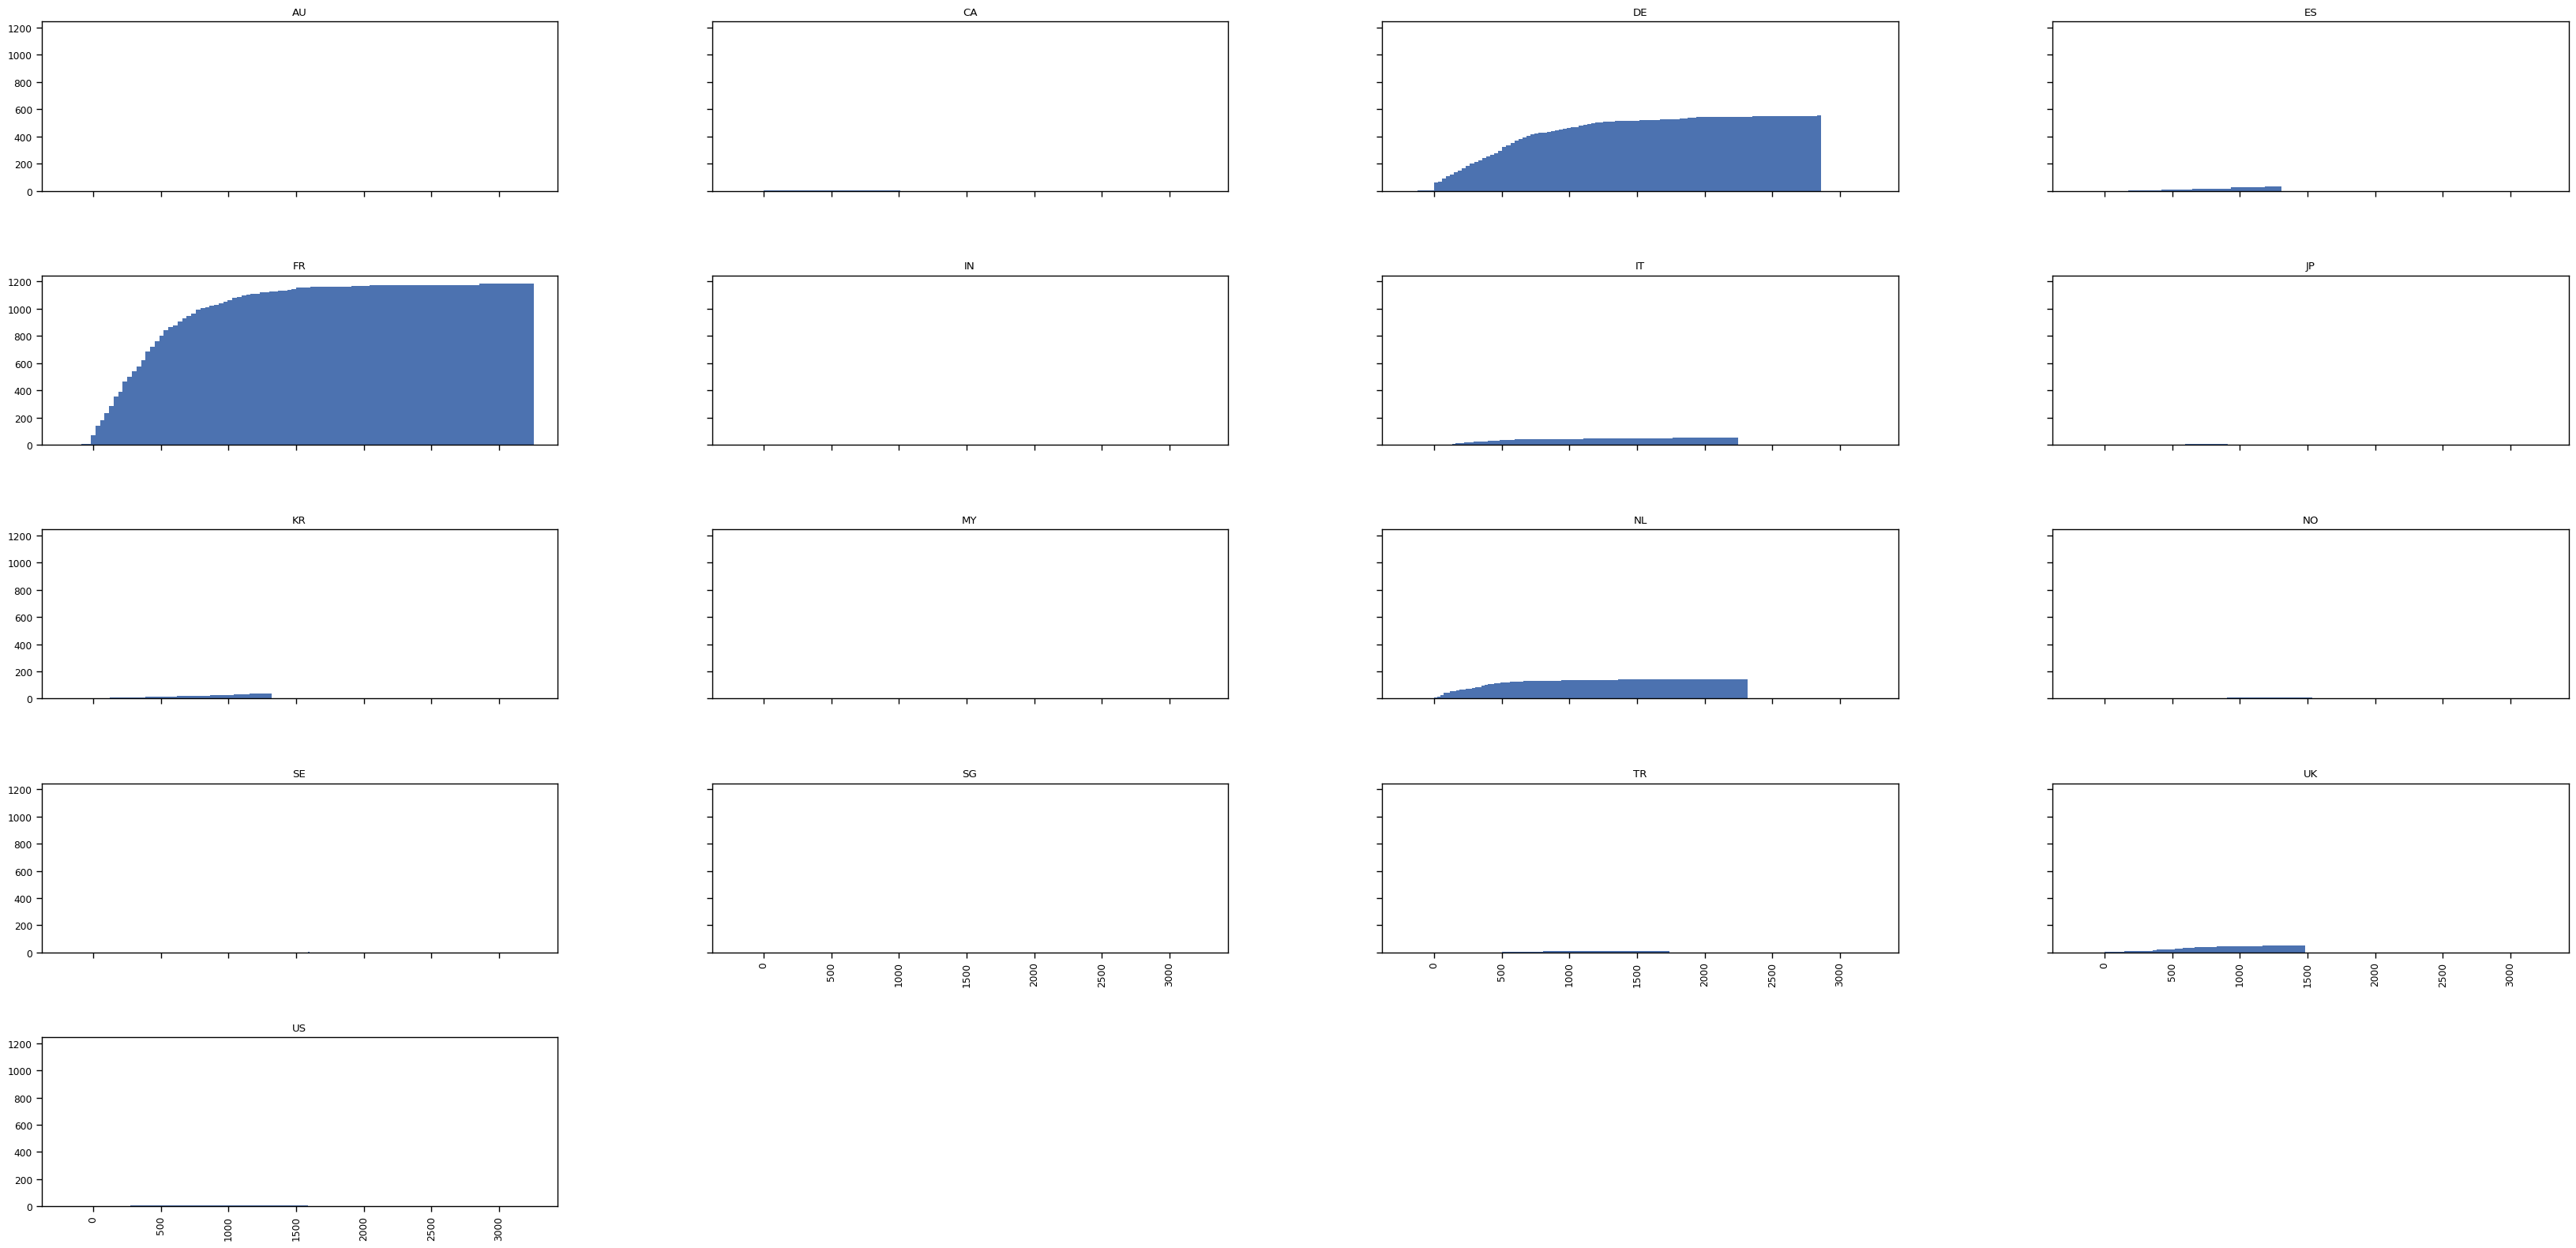

In [109]:
df.date_diff.hist(by=df.scheme, bins=100, figsize=(40, 20), sharex=True, sharey=True, cumulative=True)

<Axes: ylabel='Frequency'>

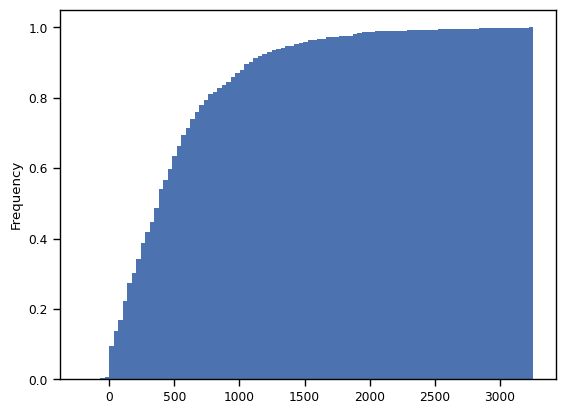

In [107]:
df.date_diff.plot.hist(bins=100, cumulative=True, density=True)